In [715]:
import xarray as xr

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from bs_fdbck.constants import path_extract_latlon_outdata
from dask.diagnostics import ProgressBar
import seaborn as sns
import numpy as np

import pandas as pd

from bs_fdbck.constants import path_measurement_data

%load_ext autoreload
%autoreload 2

from bs_fdbck.util.BSOA_datamanip import compute_total_tau, broadcase_station_data, change_units_and_compute_vars, \
    get_dic_df_mod

xr.set_options(keep_attrs=True) 

import numpy as np

import matplotlib.cm as cm
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [716]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## SET SEASON

In [717]:
season = 'MAM'

### Filename for saved plots

In [718]:
def make_fn(case, v_x, v_y, comment='', relplot = False, distplot=False):
    _x = v_x.split('(')[0]
    _y = v_y.split('(')[0]
    f = f'cloud_props_{comment}_{case}_{_x}_{_y}_{season}.png'
    if relplot:
        return plot_path_relplot/f
    if distplot:
        return plot_path_distplot/f

    return plot_path /f




plot_path = Path('Plots')
plot_path.mkdir(parents=True, exist_ok=True) 

plot_path_distplot = plot_path/'dist_plot'
plot_path_distplot.mkdir(parents=True, exist_ok=True) 

plot_path_relplot = plot_path/'rel_plot'
plot_path_relplot.mkdir(parents=True, exist_ok=True) 

## Load observational data

## LOAD MY VERSION OF SATELLITE: 

In [719]:
import pandas as pd
import numpy as np
import rioxarray as rxr
import xarray as xr
from pathlib import Path 
import time
import netCDF4

In [720]:
rn_dic = {
    'Cloud_Optical_Thickness_Liquid_Mean':'COT',
    'Cloud_Effective_Radius_Liquid_Mean': 'r_eff',
    'Cloud_Water_Path_Liquid_Mean': 'CWP',
}

In [721]:
produce_files = [
    'Cloud_Optical_Thickness_Liquid_Mean', 
    'Cloud_Effective_Radius_Liquid_Mean',
    'Cloud_Water_Path_Liquid_Mean',
    'Cloud_Water_Path_Liquid_Mean_Uncertainty',
    'Cloud_Water_Path_Liquid_Standard_Deviation',
    'Cloud_Water_Path_Liquid_Maximum',
    'Cloud_Water_Path_Liquid_Minimum',
]

In [722]:
from bs_fdbck.constants import path_measurement_data

## Settings: 

In [723]:
# path_raw_data = path_measurement_data /'satellite' / 'MODIS_raw'

# path_out_netcdf = path_measurement_data /'satellite' / 'MODIS_netcdf'


path_out_postproc = path_measurement_data /'satellite' / 'MODIS_postproc'
path_out_postproc_lev2 = path_measurement_data /'satellite' / 'MODIS_postproc_lev2'

station = 'ATTO'
sat_filename = path_out_postproc_lev2 / f'MODIS_date_{station}.nc'


fl = list(path_out_postproc.glob('*.nc'))
fl.sort()

In [724]:
sat_filename

PosixPath('/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/satellite/MODIS_postproc_lev2/MODIS_date_ATTO.nc')

In [725]:
ds_smr_sat = xr.open_dataset(sat_filename)

In [726]:
ds_smr_sat

<xarray.Dataset>
Dimensions:                                     (time: 2555, LAT: 7, LON: 15)
Coordinates:
  * time                                        (time) datetime64[ns] 2012-01...
  * LAT                                         (LAT) float64 -1.5 -2.5 ... -7.5
  * LON                                         (LON) float64 -66.5 ... -52.5
    band                                        int64 ...
Data variables: (12/19)
    CER (micrometer)                            (time, LAT, LON) float32 ...
    COT                                         (time, LAT, LON) float32 ...
    Cloud_Top_Temperature_Day_Maximum           (time, LAT, LON) float32 ...
    Cloud_Top_Temperature_Day_Mean              (time, LAT, LON) float32 ...
    Cloud_Top_Temperature_Day_Minimum           (time, LAT, LON) float32 ...
    Cloud_Water_Path_Liquid_Maximum             (time, LAT, LON) float32 ...
    ...                                          ...
    OA (microgram m^-3)                         (time) float64 ...
    N50-500                                     (time) float64 ...
    N100-500                                    (time) float64 ...
    N200-500                                    (time) float64 ...
    day_of_year                                 (time) float64 ...
    hour                                        (time) float64 ...

In [727]:
from bs_fdbck.util.BSOA_datamanip.atto import season2month

In [728]:
ds_smr_sat['is_JA'] = ds_smr_sat['time.month'].isin(season2month[season])

In [729]:
ds_smr_sat_JA = ds_smr_sat.where(ds_smr_sat['is_JA'], drop=True)

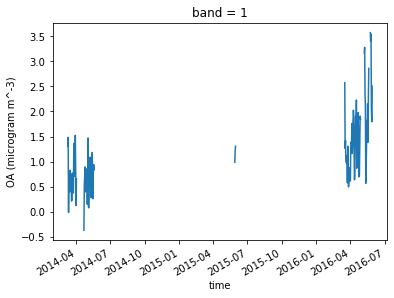

In [730]:
ds_smr_sat_JA['OA (microgram m^-3)'].plot()

In [731]:
q33 = ds_smr_sat_JA['OA (microgram m^-3)'].quantile(0.33)
q66 = ds_smr_sat_JA['OA (microgram m^-3)'].quantile(0.66)

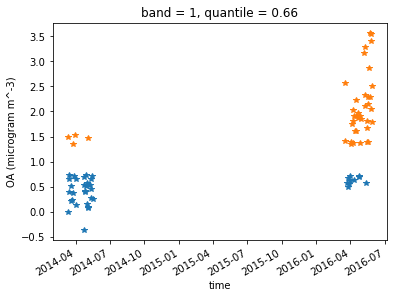

In [732]:
ds_smr_sat_JA.where(ds_smr_sat_JA['OA (microgram m^-3)']<=q33)['OA (microgram m^-3)'].plot(marker='*', linewidth=0)
ds_smr_sat_JA.where(ds_smr_sat_JA['OA (microgram m^-3)']>=q66)['OA (microgram m^-3)'].plot(marker='*', linewidth=0)

#a.isel(LAT=0,LON=0).plot(marker='*', linewidth=0)
#ds_smr_sat_JA['OA (microgram m^-3)'].isel(LAT=0,LON=0).plot(marker='*', linewidth=0)

In [733]:
varsl = ['OA (microgram m^-3)', 'CWP (g m^-2)',
       'CER (micrometer)', 'COT',]

In [734]:
ds_smr_sat_JA['OA (microgram m^-3)'],_ =xr.broadcast(ds_smr_sat_JA['OA (microgram m^-3)'],ds_smr_sat_JA['COT'])

In [735]:
ds_smr_sat_JA[varsl]

<xarray.Dataset>
Dimensions:              (time: 644, LAT: 7, LON: 15)
Coordinates:
  * time                 (time) datetime64[ns] 2012-03-01 ... 2018-05-31
  * LAT                  (LAT) float64 -1.5 -2.5 -3.5 -4.5 -5.5 -6.5 -7.5
  * LON                  (LON) float64 -66.5 -65.5 -64.5 ... -54.5 -53.5 -52.5
    band                 int64 1
Data variables:
    OA (microgram m^-3)  (time, LAT, LON) float64 nan nan nan ... nan nan nan
    CWP (g m^-2)         (time, LAT, LON) float32 nan 277.0 nan ... 67.0 nan nan
    CER (micrometer)     (time, LAT, LON) float32 nan 22.87 nan ... nan nan
    COT                  (time, LAT, LON) float32 nan 18.43 nan ... nan nan

In [736]:
ds_smr_sat_JAs = ds_smr_sat_JA[varsl]#.rename({'x':'LON','y':'LAT'})#.isel(band=0)

## Drop pixels with few obs:

In [737]:
_df = ds_smr_sat_JAs.to_dataframe().drop('band', axis=1)

df_smr_sat_JAs = _df.dropna()

In [738]:
df_smr_sat_JAs#.dropna()

OA (microgram m^-3)  CWP (g m^-2)  CER (micrometer)  \
time       LAT  LON                                                          
2014-03-10 -1.5 -64.5             1.305000          62.0         18.480000   
                -59.5             1.305000          87.0         23.109999   
                -58.5             1.305000          84.0         20.480000   
                -57.5             1.305000         104.0         20.930000   
                -56.5             1.305000         115.0         19.070000   
...                                    ...           ...               ...   
2016-05-29 -7.5 -65.5             2.503922         126.0         15.110000   
                -62.5             2.503922          95.0         22.889999   
                -57.5             2.503922          93.0         22.150000   
                -53.5             2.503922         171.0         18.389999   
                -52.5             2.503922         275.0         22.240000   

                         COT  
time       LAT  LON           
2014-03-10 -1.5 -64.5   5.17  
                -59.5   5.79  
                -58.5   6.13  
                -57.5   7.83  
                -56.5   9.08  
...                      ...  
2016-05-29 -7.5 -65.5  10.80  
                -62.5   6.40  
                -57.5   5.88  
                -53.5  16.02  
                -52.5  20.84  

[4082 rows x 4 columns]

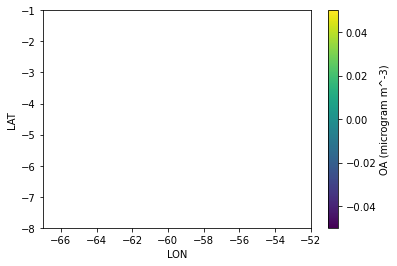

In [739]:
_df = df_smr_sat_JAs.reset_index()

da_cnt= _df.groupby([_df['LAT'],_df['LON']]).count().to_xarray()['OA (microgram m^-3)']#.plot()
da_cnt.where(da_cnt>100).plot()
da_drop_pixels = ~da_cnt.where(da_cnt>2).notnull()

In [740]:
#da_drop_pixels = ~da_cnt.notnull().rename({'lat':'LAT','lon':'LON'})

In [741]:
vl = ['FSNT','FLNT','FSNT_DRF','FLNT_DRF','FSNTCDRF','FLNTCDRF','FLNS','FSNS','FLNSC','FSNSC','FSDSCDRF','FSDS_DRF','FSUTADRF','FLUTC','FSUS_DRF','FLUS','CLOUD','FCTL','FCTI','NUCLRATE','FORMRATE','GRH2SO4','GRSOA','GR','COAGNUCL','H2SO4','SOA_LV','PS','LANDFRAC','COAGNUCL','FORMRATE','NUCLRATE','SOA_LV','H2SO4','SOA_NA','SO4_NA','NNAT_0','NCONC01','NCONC02','NCONC03','NCONC04','NCONC05','NCONC06','NCONC07','NCONC08','NCONC09','NCONC10','NCONC11','NCONC12','NCONC13','NCONC14','SIGMA01','SIGMA02','SIGMA03','SIGMA04','SIGMA05','SIGMA06','SIGMA07','SIGMA08','SIGMA09','SIGMA10','SIGMA11','SIGMA12','SIGMA13','SIGMA14','NMR01','NMR02','NMR03','NMR04','NMR05','NMR06','NMR07','NMR08','NMR09','NMR10','NMR11','NMR12','NMR13','NMR14','FSNS','FSDS_DRF','GR','GRH2SO4','GRSOA','CCN1','CCN2','CCN3','CCN4','CCN5','CCN6','CCN7','CCN_B','TGCLDCWP','cb_H2SO4','cb_SOA_LV','cb_SOA_NA','cb_SO4_NA','CLDTOT','CDNUMC','SO2','isoprene','monoterp','SOA_SV','OH_vmr','AOD_VIS','CAODVIS','CLDFREE','CDOD550','CDOD440','CDOD870','AEROD_v','CABS550','CABS550A','SOA_SEC01','SOA_SEC02','SOA_SEC03','SOA_SEC04','SOA_SEC05','SO4_SEC01','SO4_SEC02','SO4_SEC03','SO4_SEC04','SO4_SEC05','nrSOA_SEC01','nrSOA_SEC02','nrSOA_SEC03','nrSOA_SEC04','nrSOA_SEC05','nrSO4_SEC01','nrSO4_SEC02','nrSO4_SEC03','nrSO4_SEC04','nrSO4_SEC05','SOA_SEC01','SOA_SEC02','SOA_SEC03','SOA_SEC04','SOA_SEC05','SO4_SEC01','SO4_SEC02','SO4_SEC03','SO4_SEC04','SO4_SEC05','nrSOA_SEC01','nrSOA_SEC02','nrSOA_SEC03','nrSOA_SEC04','nrSOA_SEC05','nrSO4_SEC01','nrSO4_SEC02','nrSO4_SEC03','nrSO4_SEC04','nrSO4_SEC05','cb_SOA_SEC01','cb_SOA_SEC02','cb_SOA_SEC03','cb_SOA_SEC04','cb_SOA_SEC05','cb_SO4_SEC01','cb_SO4_SEC02','cb_SO4_SEC03','cb_SO4_SEC04','cb_SO4_SEC05']
vl.sort()
print(len(vl))
print(len(list(set(vl))))

163
133


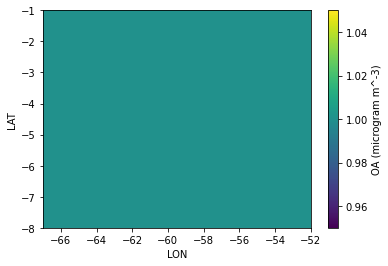

In [742]:
(~da_drop_pixels).plot()

In [743]:
ds_smr_sat_JAs = ds_smr_sat_JAs.where(~da_drop_pixels)

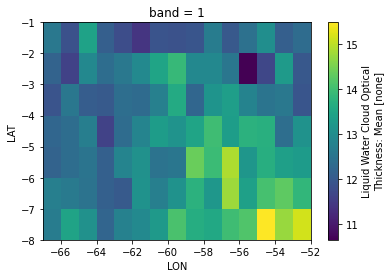

In [744]:
ds_smr_sat_JAs['COT'].mean('time').plot()

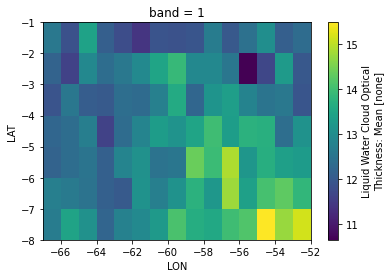

In [745]:
ds_smr_sat_JAs['COT'].mean('time').plot()

(array([ 210., 1155., 3465., 2310., 1995., 1365.,  840.,  210.,  210.,
         420.]),
 array([-0.3675  ,  0.026219,  0.419938,  0.813657,  1.207376,  1.601095,
         1.994814,  2.388533,  2.782252,  3.175971,  3.56969 ]),
 <BarContainer object of 10 artists>)

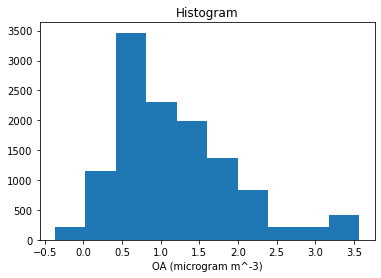

In [746]:
ds_smr_sat_JAs['OA (microgram m^-3)'].plot()
#['Org']

In [747]:
1-.33333

0.66667

In [748]:
ds_smr_sat_JAs.to_dataframe().dropna()['OA (microgram m^-3)'].quantile([0.3333333,.66666666]).values

array([0.7525   , 1.3900875])

In [749]:
[perc_33, perc_66] = ds_smr_sat_JAs.to_dataframe().dropna()['OA (microgram m^-3)'].quantile([0.3333333,.66666666]).values

In [750]:
perc_33

0.7525

In [751]:
perc_66

1.3900875

In [752]:
#df_hyy_1['OA_category']

ds_smr_sat_JAs['OA_low']= ds_smr_sat_JAs['OA (microgram m^-3)']<perc_33
ds_smr_sat_JAs['OA_high']= ds_smr_sat_JAs['OA (microgram m^-3)']>perc_66

df_smr_sat_JAs = ds_smr_sat_JAs.to_dataframe()

df_smr_sat_JAs=df_smr_sat_JAs.assign(OA_category= pd.NA)
df_smr_sat_JAs.loc[df_smr_sat_JAs['OA_high'], 'OA_category'] = 'OA high'
df_smr_sat_JAs.loc[df_smr_sat_JAs['OA_low'], 'OA_category'] = 'OA low'

#ds_smr_sat_JAs['OA_category'][ds_smr_sat_JAs['OA_high']] = 'OA high'

In [753]:
ds_smr_sat_JAs['OA_category']=df_smr_sat_JAs.to_xarray()['OA_category']

In [754]:
ds_smr_sat_JAs['OA_low'].where(ds_smr_sat_JAs['OA_low']).to_dataframe().dropna().count()

band      4305
OA_low    4305
dtype: int64

In [755]:
ds_smr_sat_JAs['OA_low'].where(ds_smr_sat_JAs['OA_low']).to_dataframe().dropna().count()

band      4305
OA_low    4305
dtype: int64

In [756]:
ds_smr_sat_JAs['OA_high'].to_dataframe().dropna().count()

band       67620
OA_high    67620
dtype: int64

In [757]:
_df = ds_smr_sat_JAs.drop('band').to_dataframe().reset_index().rename({'LAT':'lat','LON':'lon'},axis=1)#.dropna()#()

df_hyy_1 = _df.sort_values(['lat','lon']).set_index(['time','lat','lon'])

In [758]:
df_hyy_1

,,,OA (microgram m^-3),CWP (g m^-2),CER (micrometer),COT,OA_low,OA_high,OA_category
time,lat,lon,,,,,,,
2012-03-01,-7.5,-66.5,NaN,211.0,22.230000,14.690000,False,False,<NA>
2012-03-02,-7.5,-66.5,NaN,NaN,NaN,NaN,False,False,<NA>
2012-03-03,-7.5,-66.5,NaN,NaN,NaN,NaN,False,False,<NA>
2012-03-04,-7.5,-66.5,NaN,NaN,NaN,NaN,False,False,<NA>
2012-03-05,-7.5,-66.5,NaN,NaN,NaN,NaN,False,False,<NA>
...,...,...,...,...,...,...,...,...,...
2018-05-27,-1.5,-52.5,NaN,NaN,NaN,NaN,False,False,<NA>
2018-05-28,-1.5,-52.5,NaN,NaN,NaN,NaN,False,False,<NA>
2018-05-29,-1.5,-52.5,NaN,83.0,17.299999,7.560000,False,False,<NA>


#### Original binning from Yli-Juuti et al:

In [759]:
bins = pd.IntervalIndex.from_tuples([(60, 100), (100, 140), (140, 180), (180, 220), (220, 260), (260, 300), (300, 340)])

labels=[ 80, 120, 160, 200, 240, 280, 320]

df_hyy_1['CWP_cut']=pd.cut(df_hyy_1['CWP (g m^-2)'], bins=bins, labels=labels)
# label for each bin
df_hyy_1['CWP_cutl'] = df_hyy_1['CWP_cut'].apply(lambda x:x.mid)

#### Quantile binning

In [760]:
df_hyy_1['CWP (g m^-2)'].dropna()

time        lat   lon  
2012-03-01  -7.5  -66.5    211.0
2012-03-06  -7.5  -66.5    151.0
2012-03-09  -7.5  -66.5     95.0
2012-03-13  -7.5  -66.5     91.0
2012-03-14  -7.5  -66.5    184.0
                           ...  
2018-05-23  -1.5  -52.5     68.0
2018-05-24  -1.5  -52.5    353.0
2018-05-26  -1.5  -52.5    129.0
2018-05-29  -1.5  -52.5     83.0
2018-05-31  -1.5  -52.5    155.0
Name: CWP (g m^-2), Length: 21226, dtype: float32

In [761]:
df_hyy_1['CWP_qcut']=pd.qcut(df_hyy_1['CWP (g m^-2)'], 7)#bins=bins, labels=labels)
df_hyy_1['CWP_qcutl'] = df_hyy_1['CWP_qcut'].apply(lambda x:x.mid)
# Label by median in each bin
di = dict(df_hyy_1.groupby('CWP_cut').median()['CWP (g m^-2)'])
for k in di.keys():
    di[k] = int(np.round(di[k]))
df_hyy_1['CWP_cutlm'] = df_hyy_1['CWP_cut'].apply(lambda x:di[x])

#### Bin from 5th to 95th quantile of CWP and label by median in each bin or just number

In [762]:
n_bins = 6
labels = np.arange(n_bins)

qants = df_hyy_1['CWP (g m^-2)'].quantile([.0,.90])

bins2 = pd.interval_range(qants.iloc[0], qants.iloc[1], periods=n_bins)

bins2.values[-1] = pd.Interval(bins2[-1].left,np.inf)
bins2.values[0] = pd.Interval(0,bins2[0].right)


df_hyy_1['CWP_cut2']=pd.cut(df_hyy_1['CWP (g m^-2)'], bins=bins2, labels=labels)


di_per_lab = {bins2[i]:labels[i] for i in range(len(labels))}

df_hyy_1['CWP_cut2l'] = df_hyy_1['CWP_cut2'].apply(lambda x:di_per_lab[x])


di = dict(df_hyy_1.groupby('CWP_cut2').median()['CWP (g m^-2)'])
for k in di.keys():
    di[k] = int(np.round(di[k]))
df_hyy_1['CWP_cut2lm'] = df_hyy_1['CWP_cut2'].apply(lambda x:di[x])
#di = dict(df_hyy_1.groupby('CWP_cut2').mid)
#for k in di.keys():
#    di[k] = int(np.round(di[k]))
df_hyy_1['CWP_cut2lmid'] = df_hyy_1['CWP_cut2'].apply(lambda x:np.round(x.mid))


#df_hyy_1['CWP_cut2lmid'] = df_hyy_1['CWP_cut2'].apply(lambda x:x.mid)

<AxesSubplot:ylabel='Frequency'>

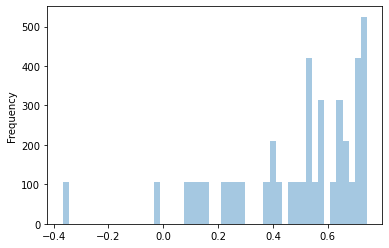

In [763]:
df_hyy_1['OA (microgram m^-3)'][df_hyy_1['OA_low']].plot.hist(bins=50, alpha=0.4, label='obs')



#df_hyy_1_old['OA (microgram m^-3)'][df_hyy_1_old['OA_low']].plot.hist(bins=50, alpha=0.4, label='obs')



In [764]:
vs =['OA (microgram m^-3)', 'CWP (g m^-2)', 'CER (micrometer)', 'COT',
       'OA_low', 'OA_high', 'OA_category']

df_smr_sat_JAsad model data:

## Load model data

In [765]:
model_name_noresm = 'NorESM'
model_name_echam  = 'ECHAM-SALSA' 
model_name_ec_earth  = 'EC-Earth' 

models =[model_name_noresm,model_name_echam,model_name_ec_earth]

### Settings

In [766]:
def lon_sh(l):
    return ((l+180)%360-180) 

def lon_sh360(l):
    return ((l)%360)

In [767]:
l=-10
((l)%360)

350

In [768]:
#lat_lims = [60, 66]
#lon_lims = [22,30]
lon_lims = [293.,308.]
#lon_lims =[lon_sh(l) for l in lon_lims]
lat_lims = [-8.,-1.]

In [769]:
#lat_lims = [60, 66]
#lon_lims = [22,30]
lon_lims = [293.,308.]
#lon_lims =[lon_sh(l) for l in lon_lims]
lat_lims = [-8.,-1.]

### NorESM

In [770]:


lat_smr = -2.150
lon_smr = 360-59.009
model_lev_i=-1

temperature = 273.15  # K


str_lonlim = '%.1f-%.1f'%(*lon_lims,)
str_latlim = '%.1f-%.1f'%(*lat_lims,)
str_coordlims = f'{str_lonlim}_{str_latlim}'
str_coordlims

'293.0-308.0_-8.0--1.0'

In [771]:
from_time1 = '2012-01-01'
to_time1 = '2015-01-01'
from_time2 ='2015-01-01'
to_time2 ='2019-01-01'

In [772]:
case_name_noresm = 'OsloAero_intBVOC_f09_f09_mg17_fssp245'

#### Input files created in [02-create_file-long_sum.ipynb](02-create_file-long_sum)

#### Input files

In [773]:
fn_noresm = path_extract_latlon_outdata/ case_name_noresm/f'{case_name_noresm}.h1._{from_time1}-{to_time2}_concat_subs_{str_coordlims}_lev1_final.nc'
fn_noresm_csv = path_extract_latlon_outdata/ case_name_noresm/f'{case_name_noresm}.h1._{from_time1}-{to_time2}_concat_subs_{str_coordlims}_lev1_finalALL_year.csv'

In [774]:

cases_noresm = [case_name_noresm]

### ECHAM-SALSA

In [775]:

case_name = 'SALSA_BSOA_feedback'
case_name_echam = 'SALSA_BSOA_feedback'
time_res = 'hour'
space_res='locations'
model_name='ECHAM-SALSA'

#### Define some strings for files

In [776]:
str_from_t = pd.to_datetime(from_time1).strftime('%Y%m')
str_to = pd.to_datetime(to_time2).strftime('%Y%m')

#### Input files:

In [777]:
input_path_echam = path_extract_latlon_outdata / model_name_echam / case_name_echam 

In [778]:
fn_final_echam = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.nc'
fn_final_echam_csv = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}ALL_year.csv'

In [779]:
cases_echam = [case_name_echam]

### EC-Earth

In [780]:

case_name = 'ECE3_output_Sara'
case_name_ec_earth = 'ECE3_output_Sara'
time_res = 'hour'
space_res='locations'
model_name='EC-Earth'
model_name_ec_earth ='EC-Earth'

#### Define some strings for files

In [781]:
str_from_t = pd.to_datetime(from_time1).strftime('%Y%m')
str_to = pd.to_datetime(to_time2).strftime('%Y%m')

#### Input files:

In [782]:
input_path_ec_earth = path_extract_latlon_outdata / model_name_ec_earth/ case_name_ec_earth

In [783]:
fn_final_ec_earth = input_path_ec_earth / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.nc'
fn_final_ec_earth_csv = input_path_ec_earth / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}ALL_year.csv'

In [784]:
fn_final_ec_earth_csv

PosixPath('/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/EC-Earth/ECE3_output_Sara/ECE3_output_Sara_2012-01-01-2019-01-01_ALL-VARS_concat_subs_293.0-308.0_-8.0--1.0ALL_year.csv')

In [785]:
cases_ec_earth = [case_name_ec_earth]

### Read in model data

In [786]:
df_mod_noresm = pd.read_csv(fn_noresm_csv, index_col=[0,1,2] )

df_mod_echam = pd.read_csv(fn_final_echam_csv, index_col=[0,1,2] )
df_mod_ec_earth = pd.read_csv(fn_final_ec_earth_csv, index_col=[0,1,2] )

In [787]:
df_mod_noresm.to_xarray()

<xarray.Dataset>
Dimensions:            (time: 2557, lat: 7, lon: 12)
Coordinates:
  * time               (time) object '2012-01-01' '2012-01-02' ... '2018-12-31'
  * lat                (lat) float64 -7.068 -6.126 -5.183 ... -2.356 -1.414
  * lon                (lon) float64 293.8 295.0 296.2 ... 305.0 306.2 307.5
Data variables: (12/102)
    station            (time, lat, lon) object 'ATTO' 'ATTO' ... 'ATTO' 'ATTO'
    FSDS_DRF           (time, lat, lon) float64 nan nan nan nan ... nan nan nan
    FSUTADRF           (time, lat, lon) float64 nan nan nan nan ... nan nan nan
    FLUTC              (time, lat, lon) float64 nan nan nan nan ... nan nan nan
    FCTI               (time, lat, lon) float64 nan nan nan nan ... nan nan nan
    FSDSCDRF           (time, lat, lon) float64 nan nan nan nan ... nan nan nan
    ...                 ...
    SOA_LV             (time, lat, lon) float64 nan nan nan ... 0.01171 0.01485
    SS_A2              (time, lat, lon) float64 nan nan ... 1.633e-09 1.633e-09
    SFmonoterp         (time, lat, lon) float64 nan nan ... 2.81e-10 3.476e-10
    SO4_A1             (time, lat, lon) float64 nan nan nan ... 0.1746 0.1746
    N150-500           (time, lat, lon) float64 nan nan nan ... 724.5 724.5
    year               (time, lat, lon) int64 2012 2012 2012 ... 2018 2018 2018

## Pick out months:

In [788]:
df_mod_noresm = df_mod_noresm[df_mod_noresm['month'].isin(season2month[season])]
df_mod_echam = df_mod_echam[df_mod_echam['month'].isin(season2month[season])]
df_mod_ec_earth = df_mod_ec_earth[df_mod_ec_earth['month'].isin(season2month[season])]

### Organize data in dictionary

In [789]:
dic_df=dict()
dic_df[model_name_echam] = df_mod_echam
dic_df[model_name_noresm] = df_mod_noresm
dic_df[model_name_ec_earth] = df_mod_ec_earth
dic_df['Observations'] = df_hyy_1

## Mask data

### NorESM: Masking if less than 5% liquid cloud top fraction and if liquid is less than 80% of the cloud top 

In [790]:
df_mod = dic_df[model_name_noresm]
mask_liq_cloudtop = (df_mod['FCTL']>0.05) & (df_mod['FCTL']/(df_mod['FCTL']+df_mod['FCTI'])>.8)

df_mod.loc[:,'mask_liq_cloudtop'] = mask_liq_cloudtop
dic_df[model_name_noresm] = df_mod[mask_liq_cloudtop]

### Scale CWP down for EC-Earth

In [791]:
_df = dic_df[model_name_ec_earth]
_df = _df.rename({'CWP':'CWP_orig'}, axis=1)
dic_df[model_name_ec_earth]  = _df

In [792]:
_df = dic_df[model_name_ec_earth]

if 'scaled' not in _df.columns:
    _df['CWP'] = _df['CWP_orig']*.7
    
    _df['scaled'] = True
dic_df[model_name_ec_earth]  = _df

## Rename variables:


In [793]:
rn_dic_echam = {
    #'cwp'      : 'CWP',
   # 'cwp_incld'      : 'CWP',
   # 'cod'      : 'COT',
    #'ceff_ct'  : 'r_eff',
   # 'ceff_ct_incld'  : 'r_eff',
    
    
}
rn_dic_ec_earth = {
    
  # 'tclw':'CWP',
}
rn_dic_noresm = {
    'TGCLDLWP_incld'         : 'CWP',
    'TOT_CLD_VISTAU_s_incld': 'COT',
    'ACTREL_incld'     : 'r_eff',
}
rn_dic_obs = {
    'CWP (g m^-2)'        : 'CWP',
    'CER (micrometer)'    : 'r_eff',
    'OA (microgram m^-3)' : 'OA',
    
}



In [794]:
test = set(dic_df[model_name_noresm].columns)

In [795]:
for key, rn in zip([model_name_noresm, model_name_echam, model_name_ec_earth,'Observations'], 
                   [rn_dic_noresm, rn_dic_echam,rn_dic_ec_earth, rn_dic_obs]):
    dic_df[key] = dic_df[key].rename(rn, axis=1)

In [796]:
test2 = set(dic_df[model_name_noresm].columns)

In [797]:
test-test2

set()

## Group by cloud water path 

#### Predefined bins

In [798]:
dic_bins = dict()
dic_bins[model_name_noresm] = pd.IntervalIndex.from_breaks([   50,  80,  110, 140, 170, 200,230, 500])
dic_bins[model_name_echam] = pd.IntervalIndex.from_breaks([   50,  80,  110, 140, 170, 200,230, 500])
dic_bins[model_name_ec_earth] = pd.IntervalIndex.from_breaks([   50,  80,  110, 140, 170, 200,230, 500])

### Bin model data:

CWP above 50. 

In [799]:
varl_categories = ['OA']#,'CLDFREE']

In [800]:
varl_categories

['OA']

In [801]:
dic_df.keys()

dict_keys(['ECHAM-SALSA', 'NorESM', 'EC-Earth', 'Observations'])

In [802]:
dic_df['EC-Earth'][['CWP']]

CWP
time       lat   lon               
2012-03-01 -7.37 293.20  175.000000
                 293.91         NaN
                 294.61   69.982910
                 295.31   50.457764
                 296.02   82.629393
...                             ...
2018-05-31 -1.05 305.16   85.491945
                 305.86         NaN
                 306.56  101.648799
                 307.27  117.337458
                 307.97   65.673461

[141680 rows x 1 columns]

In [803]:
ds_ec = dic_df['EC-Earth'].to_xarray()

In [804]:
dic_df[model_name_noresm]

station   FSDS_DRF   FSUTADRF      FLUTC     FCTI  \
time       lat       lon                                                        
2012-03-01 -7.068063 295.00    ATTO  723.83167  402.41437  271.35934  0.00000   
                     296.25    ATTO  765.78050  303.23224  270.39697  0.00000   
                     297.50    ATTO  346.17680  650.40540  264.68063  0.00000   
           -6.125654 295.00    ATTO  855.62335  268.42810  274.16740  0.00000   
           -5.183246 296.25    ATTO  413.99720  697.91990  267.00153  0.00653   
...                             ...        ...        ...        ...      ...   
2018-05-31 -1.413613 302.50    ATTO  399.17026  296.06992  292.07950  0.00000   
                     303.75    ATTO  395.18500  349.43433  291.28860  0.00000   
                     305.00    ATTO  452.41986  273.59586  288.42190  0.00000   
                     306.25    ATTO  391.73477  372.24887  281.85720  0.00000   
                     307.50    ATTO  444.48600  458.47073  279.10205  0.00000   

                               FSDSCDRF  transmittance  TGCLDCWP_incld  \
time       lat       lon                                                 
2012-03-01 -7.068063 295.00   960.68080       0.710874      196.971950   
                     296.25   962.07190       0.783974      214.940120   
                     297.50   944.49710       0.366520      215.272770   
           -6.125654 295.00  1026.69020       0.851095      113.626390   
           -5.183246 296.25  1054.05360       0.392767       78.560720   
...                                 ...            ...             ...   
2018-05-31 -1.413613 302.50   682.18695       0.731002      160.765910   
                     303.75   707.97034       0.601402       87.240380   
                     305.00   807.15424       0.680040      152.428790   
                     306.25   771.27560       0.475757       88.201454   
                     307.50   779.53420       0.503265      105.114750   

                                 FLNSC  TGCLDIWP  ...    N200-500    SO4_NA  \
time       lat       lon                          ...                         
2012-03-01 -7.068063 295.00  64.174580  0.117726  ...   70.677612  0.001005   
                     296.25  65.738884  0.014286  ...   70.677612  0.001005   
                     297.50  51.498386  0.003272  ...   70.677612  0.001005   
           -6.125654 295.00  80.726240  0.087621  ...   70.677612  0.001005   
           -5.183246 296.25  59.294563  0.288018  ...   70.677612  0.001005   
...                                ...       ...  ...         ...       ...   
2018-05-31 -1.413613 302.50  82.572110  0.000000  ...  195.385413  0.030121   
                     303.75  76.656720  0.000000  ...  195.385413  0.030121   
                     305.00  83.494576  0.000000  ...  195.385413  0.030121   
                     306.25  69.256935  0.000000  ...  195.385413  0.030121   
                     307.50  59.296345  0.000000  ...  195.385413  0.030121   

                                   OA    SOA_LV         SS_A2    SFmonoterp  \
time       lat       lon                                                      
2012-03-01 -7.068063 295.00  4.307979  0.018461  7.954414e-11  3.732819e-10   
                     296.25  4.307979  0.016270  7.954414e-11  4.231344e-10   
                     297.50  4.307979  0.021606  7.954414e-11  3.993889e-10   
           -6.125654 295.00  4.307979  0.014083  7.954414e-11  6.395460e-10   
           -5.183246 296.25  4.307979  0.026934  7.954414e-11  3.424848e-10   
...                               ...       ...           ...           ...   
2018-05-31 -1.413613 302.50  8.501748  0.017794  3.911339e-10  4.179014e-10   
                     303.75  8.501748  0.015243  3.911339e-10  2.629044e-10   
                     305.00  8.501748  0.009848  3.911339e-10  1.556824e-10   
                     306.25  8.501748  0.010575  3.911339e-10  1.203562e-10   
                     307.50  8.5017

In [805]:
ds_nor = dic_df[model_name_noresm].to_xarray()

In [806]:
_dfi = dic_df['NorESM'].T.duplicated()
for i in _dfi.index:
    if _dfi.loc[i].all():
        print(i)


ismonth1
ismonth2
ismonth6
ismonth7
ismonth8
ismonth9
ismonth10
ismonth11
ismonth12
isJuly
isAug
isJA
mask_liq_cloudtop


In [807]:
dic_df['NorESM'][['mask_liq_cloudtop','mask_liq_cloudtop']]

mask_liq_cloudtop  mask_liq_cloudtop
time       lat       lon                                         
2012-03-01 -7.068063 295.00               True               True
                     296.25               True               True
                     297.50               True               True
           -6.125654 295.00               True               True
           -5.183246 296.25               True               True
...                                        ...                ...
2018-05-31 -1.413613 302.50               True               True
                     303.75               True               True
                     305.00               True               True
                     306.25               True               True
                     307.50               True               True

[7704 rows x 2 columns]

In [808]:
if (_dfi.loc[i].all()):
    print('hi')

hi


In [809]:
list(dic_df['NorESM'].columns)

['station',
 'FSDS_DRF',
 'FSUTADRF',
 'FLUTC',
 'FCTI',
 'FSDSCDRF',
 'transmittance',
 'TGCLDCWP_incld',
 'FLNSC',
 'TGCLDIWP',
 'TOT_CLD_VISTAU_s',
 'CWP',
 'FSNSC',
 'TOT_ICLD_VISTAU_s',
 'FSNT_DRF',
 'ACTREL',
 'TOT_ICLD_VISTAU',
 'TGCLDCWP',
 'CLDTOT',
 'COT',
 'CLDFREE',
 'FSNT',
 'FLUS',
 'FLNT',
 'FSNS',
 'FCTL',
 'FREQL',
 'optical_depth',
 'TOT_CLD_VISTAU',
 'TGCLDLWP',
 'FREQI',
 'ACTNL',
 'r_eff',
 'FSNTCDRF',
 'FLNTCDRF',
 'FLNT_DRF',
 'FSUS_DRF',
 'FLNS',
 'month',
 'ismonth1',
 'ismonth2',
 'ismonth3',
 'ismonth4',
 'ismonth5',
 'ismonth6',
 'ismonth7',
 'ismonth8',
 'ismonth9',
 'ismonth10',
 'ismonth11',
 'ismonth12',
 'isJuly',
 'isAug',
 'isJA',
 'isSummer',
 'ilev',
 'lev',
 'DST_A3',
 'N100-500',
 'SFisoprene',
 'SS_A3',
 'SOA_NA',
 'BC_AI',
 'PS',
 'SOA',
 'SO4_A2',
 'DOD440',
 'SOA_A1',
 'BC_NI',
 'BC_AX',
 'BC_AC',
 'OM_AC',
 'OM_NI',
 'DST_A2',
 'SO4_PR',
 'N100',
 'H2SO4',
 'FORMRATE',
 'NCONC01',
 'OM_AI',
 'N150',
 'N200',
 'COAGNUCL',
 'N50',
 'T_C',
 'BC_

In [810]:
ds_no = dic_df['NorESM'].to_xarray()

In [811]:
n_bins = 6

for model_name in models:
    print(model_name)
    df_mod = dic_df[model_name]
    

    bins = dic_bins[model_name]
    df_mod['CWP_cut']=pd.cut(df_mod['CWP'], bins=bins)#, labels=labels)

    
    df_mod['CWP_cutl'] = df_mod['CWP_cut'].apply(lambda x:x.mid)
    di = dict(df_mod.groupby('CWP_cut').median()['CWP'])
    for k in di.keys():
        di[k] = int(np.round(di[k]))
    df_mod['CWP_cutlm'] = df_mod['CWP_cut'].apply(lambda x:di[x])
    
    labels = np.arange(n_bins)
    # bins from 5th to 95th percentile
    qants = df_mod['CWP'].quantile([.0,.90])
    bins2 = pd.interval_range(qants.iloc[0], qants.iloc[1], periods=n_bins)
    bins2.values[-1] = pd.Interval(bins2[-1].left,np.inf)
    bins2.values[0] = pd.Interval(0,bins2[0].right)
 
    df_mod['CWP_cut2']=pd.cut(df_mod['CWP'], bins=bins2, labels=labels)
    di_per_lab = {bins2[i]:labels[i] for i in range(len(labels))}

    df_mod['CWP_cut2l'] = df_mod['CWP_cut2'].apply(lambda x:di_per_lab[x])
    # median label: 
    di = dict(df_mod.groupby('CWP_cut2').median()['CWP'])
    for k in di.keys():
        di[k] = int(np.round(di[k]))
    df_mod['CWP_cut2lm'] = df_mod['CWP_cut2'].apply(lambda x:di[x])
    
    #di = dict(df_mod.groupby('CWP_cut2').unique().mid)
    #for k in di.keys():
    #    di[k] = int(np.round(di[k]))
    df_mod['CWP_cut2lmid'] = df_mod['CWP_cut2'].apply(lambda x:np.round(x.mid))
    
    for v in varl_categories:
        q34 = df_mod[v].quantile(.3333333)
        print(q34)
        
        q66 = df_mod[v].quantile(.6666666)
        print(q66)
        df_mod[f'{v}_low'] = df_mod[v]<q34
        df_mod[f'{v}_high']= df_mod[v]>q66
        mid_range = ( df_mod[v].quantile(.34)<df_mod[v]) & (df_mod[v]<df_mod[v].quantile(.66))
        df_mod[f'{v}_mid_range'] = mid_range
        df_mod=df_mod.assign(**{f'{v}_category': pd.NA})
        df_mod.loc[df_mod[f'{v}_high'], f'{v}_category'] = f'{v} high'
        df_mod.loc[df_mod[f'{v}_low'], f'{v}_category'] = f'{v} low'
        dic_df[model_name] = df_mod

NorESM
3.5176387
6.2193492500000005
ECHAM-SALSA
0.5717164699999999
1.3770919
EC-Earth
1.5204490448954076
2.041975203158821


## Quantile cut

In [812]:
for key in dic_df.keys():
    df_mod = dic_df[key]
    df_mod['CWP_qcut']=pd.qcut(df_mod['CWP'],6)# bins=bins, labels=labels)§
    df_mod['CWP_qcutl'] = df_mod['CWP_qcut'].apply(lambda x:x.mid)
    dic_df[key] = df_mod

# Distribution plots:

In [813]:
palette = 'Set2'

In [814]:
#cmap = cm.get_cmap(name=palette, )
cmap_list = ['#441FE0','#BBE01F'][::-1]#cmap(a) for a in np.linspace(0,1,8)]

palette_OA = cmap_list[0:2]

In [815]:
for key in dic_df.keys():
    _df = dic_df[key].copy()
    #_df = _df[_df[v_x]<x_cut]
    print(key)
    print(len(_df.dropna().reset_index()['time'].unique()))
    #_df.reset_index()['time'].unique().plot()

ECHAM-SALSA
428
NorESM
387
EC-Earth
426
Observations
73


21226
Plots/dist_plot/cloud_props_distribution_mod_obs_COT_count_MAM.png


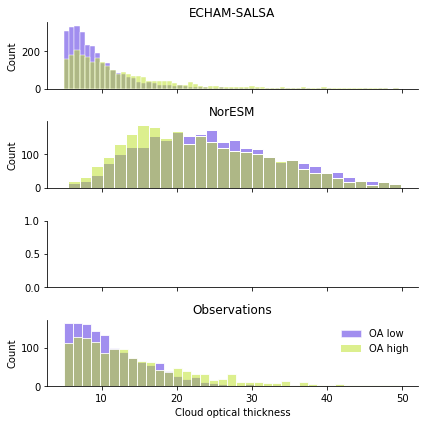

In [816]:
fig, axs = plt.subplots(4,1, sharex=True, figsize =[6,6])
v_x = 'COT'
x_cut = 100
v_hue = 'OA_category'
hue_order=['OA low', 'OA high'][::-1]

_palette = palette_OA#cmap_list[0:2]


for key, ax in zip(dic_df.keys(), axs):
    if key=='EC-Earth':
        continue
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]

    sns.histplot(
        x=v_x,
        data=_df,
        hue=v_hue,
        hue_order=hue_order,
        palette=_palette,
        legend=False,
        edgecolor='w',
        ax = ax
    )
#plt.ylim([0,250])
    ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud optical thickness')
#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)



20994
Plots/dist_plot/cloud_props_distribution_mod_obs_CWP_count_MAM.png


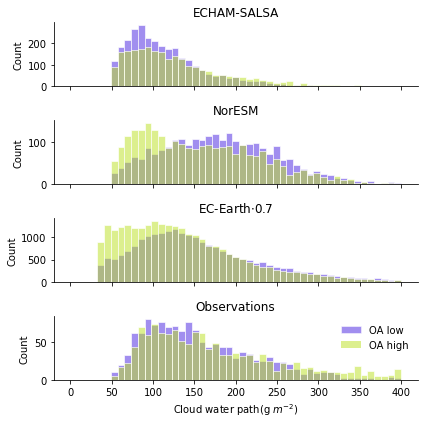

In [817]:
fig, axs = plt.subplots(4,1, sharex=True, figsize =[6,6])
_bins = np.linspace(0,400)
v_x = 'CWP'
x_cut = 500
v_hue = 'OA_category'
hue_order=['OA low', 'OA high'][::-1]

_palette = palette_OA#cmap_list[0:2]


for key, ax in zip(dic_df.keys(), axs):
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]

    sns.histplot(
        x=v_x,
        data=_df,
        hue=v_hue,
        hue_order=hue_order,
        palette=_palette,
        legend=False,
        edgecolor='w',
        ax = ax,
        bins = _bins,
    )
    if (key=='EC-Earth') and ('scaled' in _df.columns):
        title = f'{key}$\cdot$0.7'
    else:
        title = key
#plt.ylim([0,250])
    ax.set_title(title)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud water path(g $m^{-2}$)')

#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)



1344
Plots/dist_plot/cloud_props_distribution_mod_obs_CWP_count_MAM.png


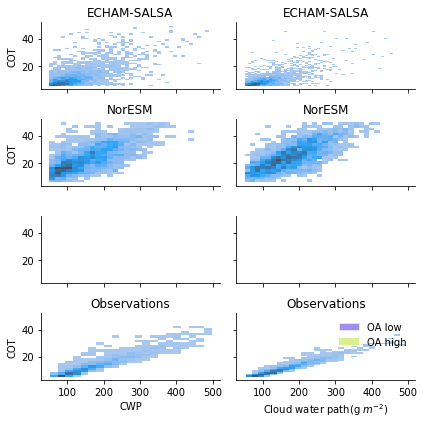

In [818]:
fig, axs = plt.subplots(4,2,  figsize =[6,6], sharex=True, sharey=True)

v_x = 'CWP'
v_y = 'COT'
x_cut = 500
v_hue = 'OA_category'
hue_order=['OA low', 'OA high'][::-1]

_palette = palette_OA#cmap_list[0:2]


for i, key in enumerate(dic_df.keys()):
    if key=='EC-Earth':
        continue
    axs_sub = axs[i,:]
    for hue_v, ax in zip(hue_order, axs_sub):
        _df = dic_df[key].copy()
        _df = _df[_df[v_x]<x_cut]
        _df = _df[_df[v_hue]==hue_v]
    
        sns.histplot(
            x=v_x,
            y=v_y, 
            data=_df,
            #hue=v_hue,
            #hue_order=hue_order,
#            palette=_palette,
            legend=False,
        #edgecolor='w',
        ax = ax
        )
        #plt.ylim([0,250])
        ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud water path(g $m^{-2}$)')

#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
#fig.savefig(fn, dpi=150)
#fig.savefig(fn.with_suffix('.pdf'), dpi=150)



1344
Plots/dist_plot/cloud_props_distribution_mod_obs_CWP_count_MAM.png


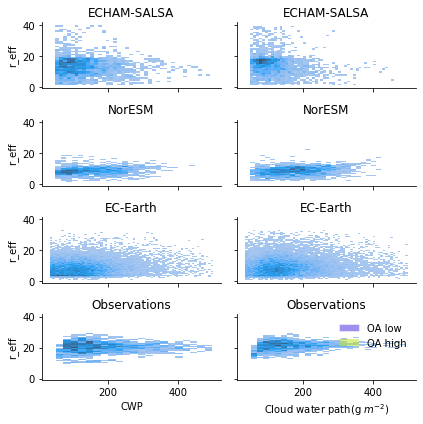

In [819]:
fig, axs = plt.subplots(4,2,  figsize =[6,6], sharex=True, sharey=True)

v_x = 'CWP'
v_y = 'r_eff'
x_cut = 500
y_cut = 40
v_hue = 'OA_category'
hue_order=['OA low', 'OA high'][::-1]

_palette = palette_OA#cmap_list[0:2]


for i, key in enumerate(dic_df.keys()):
    #if key=='EC-Earth':
    #    continue
    axs_sub = axs[i,:]
    for hue_v, ax in zip(hue_order, axs_sub):
        _df = dic_df[key].copy()
        _df = _df[_df[v_x]<x_cut]
        _df = _df[_df[v_y]<y_cut]
        _df = _df[_df[v_hue]==hue_v]
    
        sns.histplot(
            x=v_x,
            y=v_y, 
            data=_df,
            #hue=v_hue,
            #hue_order=hue_order,
#            palette=_palette,
            legend=False,
        #edgecolor='w',
        ax = ax
        )
        #plt.ylim([0,250])
        ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud water path(g $m^{-2}$)')

#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
#fig.savefig(fn, dpi=150)
#fig.savefig(fn.with_suffix('.pdf'), dpi=150)



In [820]:
hue_v = 'OA high'

20994
Plots/dist_plot/cloud_props_distribution_mod_obs_CWP_count_MAM.png


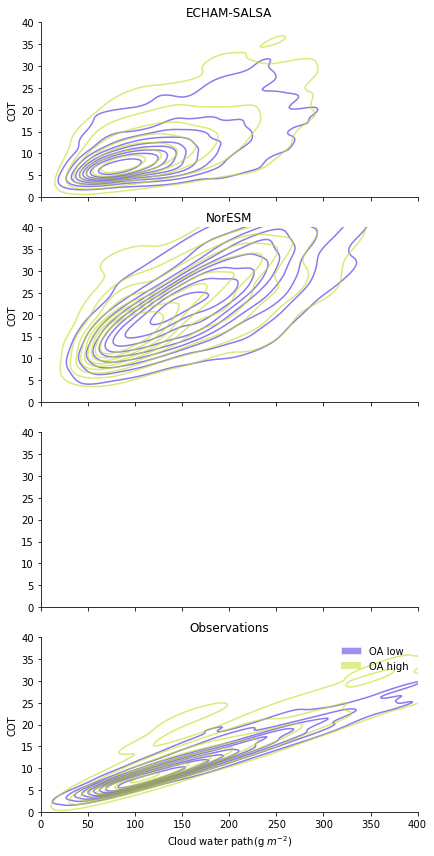

In [821]:
fig, axs = plt.subplots(4,1,  figsize =[6,12], sharex=True, sharey=True)

v_x = 'CWP'
v_y = 'COT'
x_cut = 500
v_hue = 'OA_category'
hue_order=['OA low', 'OA high']

_palette = palette_OA[::-1]#cmap_list[0:2]


for ax, key in zip(axs, dic_df.keys()):
    if key=='EC-Earth':
        continue
    #for hue_v, ax in zip(hue_order, axs):
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]
    #_df = _df[_df[v_hue]==hue_v]
    sns.kdeplot(
            x=v_x,
            y=v_y, 
            data=_df,
            hue=v_hue,
            hue_order=hue_order,
            palette=_palette,
        #alpha=0.5
            legend=False,
        alpha=.6,
        #edgecolor='w',
        ax = ax
    )
        #plt.ylim([0,250])
    ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[0], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[1], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud water path(g $m^{-2}$)')

#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
#fig.savefig(fn, dpi=150)
#fig.savefig(fn.with_suffix('.pdf'), dpi=150)

for ax in axs:
    ax.set_xlim([0,400])
    ax.set_ylim([0,40])    

21226
Plots/dist_plot/cloud_props_distribution_mod_obs_r_eff_count_MAM.png


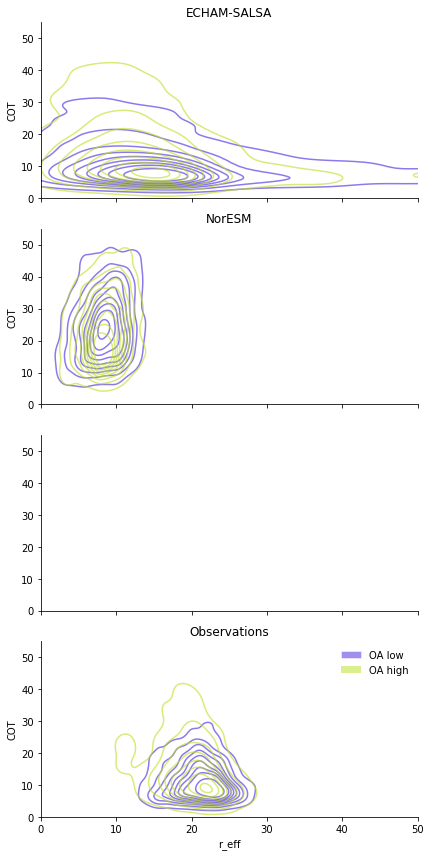

In [822]:
fig, axs = plt.subplots(4,1,  figsize =[6,12], sharex=True, sharey=True)

v_x = 'r_eff'
v_y = 'COT'
x_cut = 500
v_hue = 'OA_category'
hue_order=['OA low', 'OA high']

_palette = palette_OA[::-1]#cmap_list[0:2]


for ax, key in zip(axs, dic_df.keys()):
    if key =='EC-Earth':
        continue
    #for hue_v, ax in zip(hue_order, axs):
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]
    #_df = _df[_df[v_hue]==hue_v]
    sns.kdeplot(
            x=v_x,
            y=v_y, 
            data=_df,
            hue=v_hue,
            hue_order=hue_order,
            palette=_palette,
        #alpha=0.5
            legend=False,
        alpha=.6,
        #edgecolor='w',
        ax = ax
    )
        #plt.ylim([0,250])
    ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[0], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[1], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel(v_x)
ax.set_ylabel(v_y)

#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
#fig.savefig(fn, dpi=150)
#fig.savefig(fn.with_suffix('.pdf'), dpi=150)

for ax in axs:
    ax.set_xlim([0,50])
    ax.set_ylim([0,55])    

20994
Plots/dist_plot/cloud_props_distribution_mod_obs_CWP_count_MAM.png


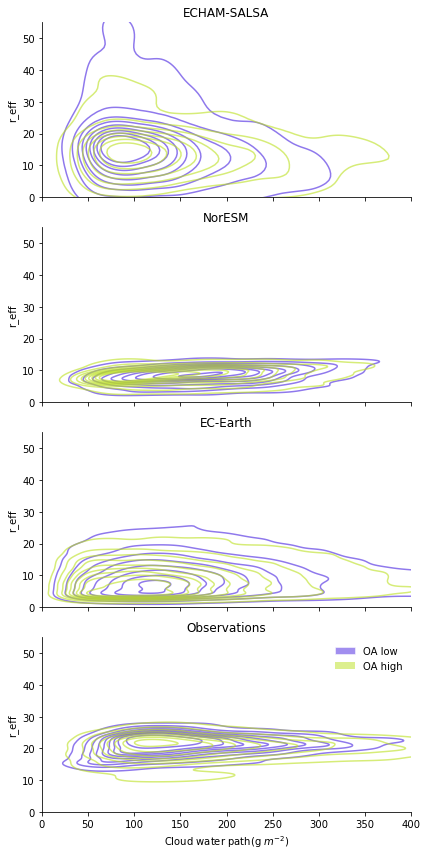

In [823]:
fig, axs = plt.subplots(4,1,  figsize =[6,12], sharex=True, sharey=True)

v_y = 'r_eff'
v_x = 'CWP'
x_cut = 500
v_hue = 'OA_category'
hue_order=['OA low', 'OA high']

_palette = palette_OA[::-1]#cmap_list[0:2]


for ax, key in zip(axs, dic_df.keys()):
    #for hue_v, ax in zip(hue_order, axs):
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]
    #_df = _df[_df[v_hue]==hue_v]
    sns.kdeplot(
            x=v_x,
            y=v_y, 
            data=_df,
            hue=v_hue,
            hue_order=hue_order,
            palette=_palette,
        #alpha=0.5
            legend=False,
        alpha=.6,
        #edgecolor='w',
        ax = ax
    )
        #plt.ylim([0,250])
    ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[0], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[1], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud water path(g $m^{-2}$)')

#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
#fig.savefig(fn, dpi=150)
#fig.savefig(fn.with_suffix('.pdf'), dpi=150)

for ax in axs:
    ax.set_xlim([0,400])
    ax.set_ylim([0,55])    

In [824]:
s = dic_df[model_name_echam]['r_eff']#*dic_df[model_name_echam]['cl_time']
s = s[0<s]
len(s[s.notna()])

8117

In [825]:
len(dic_df['ECHAM-SALSA'].dropna())

4922

In [826]:
len(dic_df['NorESM'].dropna())

5130

8117
7704
76958
21226
Plots/dist_plot/cloud_props_distribution_mod_obs_r_eff_count_MAM.png


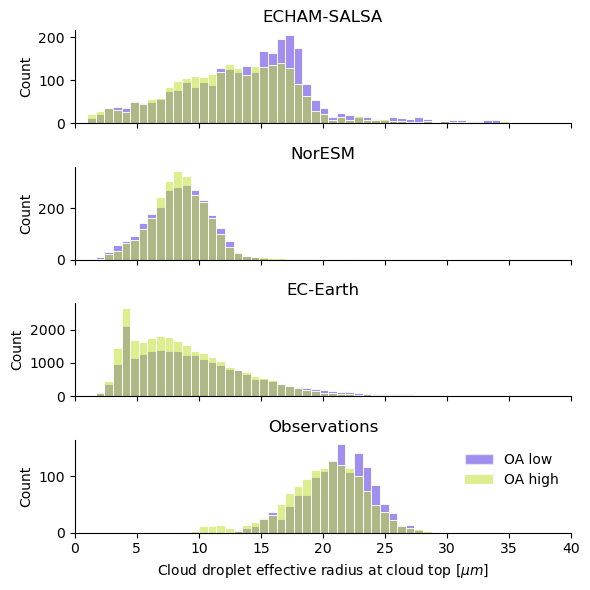

In [827]:
fig, axs = plt.subplots(4,1, sharex=True, figsize =[6,6], dpi=100)

v_x = 'r_eff'
x_cut = 700
_bins = np.linspace(1, 35)
v_hue = 'OA_category'
hue_order=['OA low', 'OA high'][::-1]
_palette = palette_OA#cmap_list[0:2]


for key, ax in zip(dic_df.keys(), axs):
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]
    _df = _df[_df[v_x]>0]

    sns.histplot(
        x=v_x,
        data=_df,
        hue=v_hue,
        hue_order=hue_order,
        palette=_palette,
        legend=False,
        edgecolor='w',
        bins = _bins,
        ax = ax
    )
    #plt.ylim([0,250])
    ax.set_title(key)#'Observations')
    print(len(_df))
    


custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud droplet effective radius at cloud top [$\mu m$]')

#plt.ylim([0,250])
sns.despine(fig)

for ax in axs: 
    ax.set_xlim([0,40])
fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)
#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)



In [828]:
df_ec_earth = dic_df['EC-Earth']
df_ec_earth = df_ec_earth[df_ec_earth['r_eff']>=5]
dic_df['EC-Earth'] = df_ec_earth

In [829]:
ds_ech = dic_df['ECHAM-SALSA'].to_xarray()

In [830]:
ds_nor = dic_df['NorESM'].to_xarray()

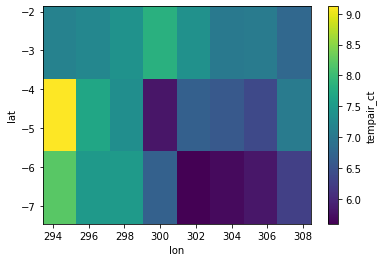

In [831]:
(ds_ech['tempair_ct'].mean('time')-273.15).plot()

In [832]:
ds_ech

<xarray.Dataset>
Dimensions:         (time: 644, lat: 3, lon: 8)
Coordinates:
  * time            (time) object '2012-03-01' '2012-03-02' ... '2018-05-31'
  * lat             (lat) float64 -6.528 -4.663 -2.798
  * lon             (lon) float64 294.4 296.2 298.1 300.0 ... 303.8 305.6 307.5
Data variables: (12/67)
    station         (time, lat, lon) object 'ATTO' 'ATTO' ... 'ATTO' 'ATTO'
    ceff_ct         (time, lat, lon) float64 nan nan nan 15.07 ... nan nan nan
    lcdnc_ct_incld  (time, lat, lon) float64 nan nan nan ... nan nan nan
    lcdnc_ct        (time, lat, lon) float64 nan nan nan ... nan nan nan
    lcdnc_ct_cm3    (time, lat, lon) float64 nan nan nan 49.79 ... nan nan nan
    ceff            (time, lat, lon) float64 nan nan nan ... nan nan nan
    ...              ...
    OA_low          (time, lat, lon) bool False False False ... False False
    OA_high         (time, lat, lon) bool False False False ... False False
    OA_mid_range    (time, lat, lon) bool True True True True ... True True True
    OA_category     (time, lat, lon) object <NA> <NA> <NA> ... <NA> <NA> <NA>
    CWP_qcut        (time, lat, lon) object nan nan nan ... nan nan nan
    CWP_qcutl       (time, lat, lon) float64 nan nan nan 80.89 ... nan nan nan

In [833]:
ds_ech

<xarray.Dataset>
Dimensions:         (time: 644, lat: 3, lon: 8)
Coordinates:
  * time            (time) object '2012-03-01' '2012-03-02' ... '2018-05-31'
  * lat             (lat) float64 -6.528 -4.663 -2.798
  * lon             (lon) float64 294.4 296.2 298.1 300.0 ... 303.8 305.6 307.5
Data variables: (12/67)
    station         (time, lat, lon) object 'ATTO' 'ATTO' ... 'ATTO' 'ATTO'
    ceff_ct         (time, lat, lon) float64 nan nan nan 15.07 ... nan nan nan
    lcdnc_ct_incld  (time, lat, lon) float64 nan nan nan ... nan nan nan
    lcdnc_ct        (time, lat, lon) float64 nan nan nan ... nan nan nan
    lcdnc_ct_cm3    (time, lat, lon) float64 nan nan nan 49.79 ... nan nan nan
    ceff            (time, lat, lon) float64 nan nan nan ... nan nan nan
    ...              ...
    OA_low          (time, lat, lon) bool False False False ... False False
    OA_high         (time, lat, lon) bool False False False ... False False
    OA_mid_range    (time, lat, lon) bool True True True True ... True True True
    OA_category     (time, lat, lon) object <NA> <NA> <NA> ... <NA> <NA> <NA>
    CWP_qcut        (time, lat, lon) object nan nan nan ... nan nan nan
    CWP_qcutl       (time, lat, lon) float64 nan nan nan 80.89 ... nan nan nan

In [834]:
ds_nor['COT'].count()

<xarray.DataArray 'COT' ()>
array(7704)

In [835]:
ds_ech.where(ds_ech['cl_time_ct']>.9)['COT'].count()

<xarray.DataArray 'COT' ()>
array(4462)

In [836]:
ds_ech

<xarray.Dataset>
Dimensions:         (time: 644, lat: 3, lon: 8)
Coordinates:
  * time            (time) object '2012-03-01' '2012-03-02' ... '2018-05-31'
  * lat             (lat) float64 -6.528 -4.663 -2.798
  * lon             (lon) float64 294.4 296.2 298.1 300.0 ... 303.8 305.6 307.5
Data variables: (12/67)
    station         (time, lat, lon) object 'ATTO' 'ATTO' ... 'ATTO' 'ATTO'
    ceff_ct         (time, lat, lon) float64 nan nan nan 15.07 ... nan nan nan
    lcdnc_ct_incld  (time, lat, lon) float64 nan nan nan ... nan nan nan
    lcdnc_ct        (time, lat, lon) float64 nan nan nan ... nan nan nan
    lcdnc_ct_cm3    (time, lat, lon) float64 nan nan nan 49.79 ... nan nan nan
    ceff            (time, lat, lon) float64 nan nan nan ... nan nan nan
    ...              ...
    OA_low          (time, lat, lon) bool False False False ... False False
    OA_high         (time, lat, lon) bool False False False ... False False
    OA_mid_range    (time, lat, lon) bool True True True True ... True True True
    OA_category     (time, lat, lon) object <NA> <NA> <NA> ... <NA> <NA> <NA>
    CWP_qcut        (time, lat, lon) object nan nan nan ... nan nan nan
    CWP_qcutl       (time, lat, lon) float64 nan nan nan 80.89 ... nan nan nan

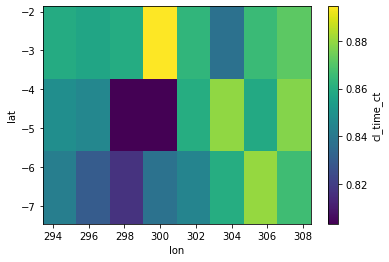

In [837]:
(ds_ech['cl_time_ct'].mean('time')).plot()#vmin=100, vmax=160)

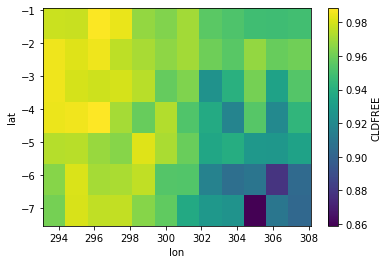

In [838]:
(1-ds_nor['CLDFREE'].mean('time')).plot()

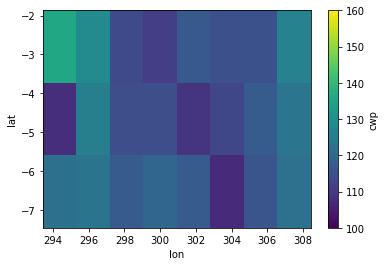

In [839]:
(ds_ech['cwp'].mean('time')).plot(vmin=100, vmax=160)

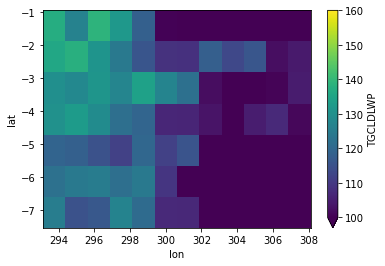

In [840]:
(ds_nor['TGCLDLWP'].mean('time')).plot(vmin=100, vmax=160)

In [841]:
dic_df[model_name_echam] = dic_df[model_name_echam][dic_df[model_name_echam]['cl_time_ct']>0.9]
dic_df[model_name_echam]

station    ceff_ct  lcdnc_ct_incld     lcdnc_ct  \
time       lat       lon                                                       
2012-03-01 -2.797890 300.000    ATTO  10.803152       1735620.4    1301715.2   
                     305.625    ATTO  15.816598       2983160.0    2610265.0   
           -4.663150 294.375    ATTO   4.068588       1128190.0    1128190.0   
                     301.875    ATTO   8.826511        605942.4     605942.4   
                     305.625    ATTO  12.409493       2198276.8    2198276.8   
...                              ...        ...             ...          ...   
2018-05-30 -6.528409 307.500    ATTO   7.944233     161432380.0  161432380.0   
2018-05-31 -2.797890 298.125    ATTO  15.568005       1877004.5    1877004.5   
           -4.663150 298.125    ATTO  15.960016       3339520.8    3339520.8   
                     303.750    ATTO   7.773715     114580880.0  114580880.0   
           -6.528409 307.500    ATTO  11.852790      44569850.0   44569850.0   

                              lcdnc_ct_cm3  ceff         CWP  cl_time_ct  \
time       lat       lon                                                   
2012-03-01 -2.797890 300.000      1.301715   0.0  114.584870         1.0   
                     305.625      2.610265   0.0   78.118810         1.0   
           -4.663150 294.375      1.128190   0.0  132.125080         1.0   
                     301.875      0.605942   0.0   93.713524         1.0   
                     305.625      2.198276   0.0   96.040146         1.0   
...                                    ...   ...         ...         ...   
2018-05-30 -6.528409 307.500    161.432390   0.0   86.616970         1.0   
2018-05-31 -2.797890 298.125      1.877004   0.0   64.214160         1.0   
           -4.663150 298.125      3.339521   0.0   92.471730         1.0   
                     303.750    114.580880   0.0   65.151375         1.0   
           -6.528409 307.500     44.569847   0.0   84.103260         1.0   

                              clfr_mask  clfr  ...  \
time       lat       lon                       ...   
2012-03-01 -2.797890 300.000        1.0   0.0  ...   
                     305.625        1.0   0.0  ...   
           -4.663150 294.375        1.0   0.0  ...   
                     301.875        0.0   0.0  ...   
                     305.625        1.0   0.0  ...   
...                                 ...   ...  ...   
2018-05-30 -6.528409 307.500        1.0   0.0  ...   
2018-05-31 -2.797890 298.125        1.0   0.0  ...   
           -4.663150 298.125        1.0   0.0  ...   
                     303.750        1.0   0.0  ...   
           -6.528409 307.500        1.0   0.0  ...   

                                                             CWP_cut2  \
time       lat       lon                                                
2012-03-01 -2.797890 300.000  (98.90916333333335, 123.36185000000003]   
                     305.625   (74.45647666666667, 98.90916333333335]   
           -4.663150 294.375  (123.36185000000003, 147.8145366666667]   
                     301.875   (74.45647666666667, 98.90916333333335]   
                     305.625   (74.45647666666667, 98.90916333333335]   
...                                                               ...   
2018-05-30 -6.528409 307.500   (74.45647666666667, 98.90916333333335]   
2018-05-31 -2.797890 298.125                 (0.0, 74.45647666666667]   
           -4.663150 298.125   (74.45647666666667, 98.90916333333335]   
                     303.750                 (0.0, 74.45647666666667]   
           -6.528409 307.500   (74.45647666666667, 98.90916333333335]   

                              CWP_cut2l  CWP_cut2lm  CWP_cut2lmid  OA_low  \
time       lat       lon                                                    
2012-03-01 -2.797890 300.000          2         109         111.0   False   
                     305.625          1          86          87.0   False   
           -4.663150 294.375          

In [842]:
dic_df[model_name_echam] = dic_df[model_name_echam][dic_df[model_name_echam]['r_eff']>5]

# Calculate difference between high OA and low


In [843]:
from bs_fdbck.util.plot.BSOA_plots import cdic_model

In [844]:
hue_order = ['OA low','OA high']#[::-1]
palette_OA_2 = palette_OA[::-1]

In [845]:
order_keys = [model_name_noresm, model_name_echam, 'Observations']

In [846]:
from sklearn.utils import resample

## Bootstrap resampling 

In [847]:
def bootstrap_subset(_df_low,_df_high, var='COT', category='CWP_cutlm', itts=10000):      
    


    cat_cats = list(_df_low[category][_df_low[category].notna()].unique())
    cat_cats.sort()

    df_sample_med = pd.DataFrame(columns=cat_cats, index = range(itts))

    df_sample_med

    for ca in cat_cats:
        _df_lc = _df_low[_df_low[category]==ca]
        _df_hc = _df_high[_df_high[category]==ca]
        print(f'length of {ca} is {len(_df_lc)} and {len(_df_hc)}')
        print(f'number of days is {len(_df_lc.reset_index().time.unique())} and {len(_df_hc.reset_index().time.unique())}')
        list_diff_meds = list()
        for it in range(itts):
            boot_l =resample(_df_lc[var])
            boot_h =resample(_df_hc[var])
    
            diff_median = boot_h.median()- boot_l.median()
            list_diff_meds.append(diff_median)
        print(len(list_diff_meds))
        df_sample_med[ca] = list_diff_meds
    
    return df_sample_med
    
def bootstrap_return_quantiles(_df_low,_df_high, 
                               quantiles = None,
                               var='COT', category='CWP_cutlm', itts=10000):
    if quantiles is None:
        quantiles =[0.05, 0.5, 0.95]
    df_sample_med= bootstrap_subset(_df_low,_df_high, var=var, category=category, itts=itts)
    
    return df_sample_med.quantile(quantiles)
    
    
    #oob = [x for x in _df_low[var] if x not in boot]
    #print(resample(_df_low).median())
    #print(_df_low.median())
    
        

## Calculate CIs with bootstrap

In [848]:
hue_labs = ['OA low', 'OA high']
hue_var = 'OA_category'

itterations = 1000



x_var = 'CWP_cut2lm'
y_var1 = 'COT'
y_var2 = 'r_eff'



dic_median_CI = dict()
for ax, y_var in zip(axs,[y_var1, y_var2]):
    dic_median_CI[y_var] = dict()
    for key in dic_df.keys():
        print(key)
        if (key =='EC-Earth') and (y_var=='COT'):
            continue
        _df = dic_df[key].copy()
    
        _df_lim =_df.copy() 
        notna = (_df_lim[x_var].notna() & _df_lim[y_var].notna())&(_df_lim[hue_var].notna())
        _df_lim = _df_lim[notna]
        print('Total number of days:')
        print(len(_df_lim.reset_index()['time'].unique()))
        #_df_lim = _df_lim[_df_lim[y_var].notna()]
        #_df_lim = _df_lim[_df_lim[hue_var].notna()]
    
        _df_low = _df_lim[_df_lim[hue_var] == hue_labs[0]]
        _df_high = _df_lim[_df_lim[hue_var] == hue_labs[1]]
        
        med_low = _df_low.groupby(x_var).median()
        med_high = _df_high.groupby(x_var).median()
        #std_low = _df_low.groupby(x_var).std()
        #std_high = _df_high.groupby(x_var).std()
        n_low = _df_low.groupby(x_var).count()['OA_category']
        n_high = _df_high.groupby(x_var).count()['OA_category']
        df_numb = pd.DataFrame()
        df_numb['n_low'] = n_low
        df_numb['n_high'] = n_high
        df_numb['n_str'] = df_numb['n_low'].astype(str) + '/' + df_numb['n_high'].astype(str) 
        
    
    
        diff_med = med_high-med_low
        
        df_sample_quant =bootstrap_return_quantiles(_df_low,_df_high, 
                               quantiles = None,
                               var=y_var, category=x_var, itts=itterations)
        #df_bs_samp_med = df_sample_quant.loc[0.5]
        dic_median_CI[y_var][key]=dict()
        dic_median_CI[y_var][key]['sample_median']=diff_med.copy()
        dic_median_CI[y_var][key]['bootstrap_quant']=df_sample_quant.copy()
        dic_median_CI[y_var][key]['number']=df_numb#['n_str']

ECHAM-SALSA
Total number of days:
426
length of 64 is 242 and 266
number of days is 143 and 150
1000
length of 86 is 346 and 278
number of days is 177 and 147
1000
length of 109 is 244 and 242
number of days is 142 and 139
1000
length of 134 is 180 and 203
number of days is 123 and 122
1000
length of 159 is 98 and 137
number of days is 78 and 86
1000
length of 212 is 195 and 337
number of days is 108 and 147
1000
NorESM
Total number of days:
387
length of 72 is 215 and 447
number of days is 106 and 118
1000
length of 103 is 351 and 541
number of days is 141 and 152
1000
length of 140 is 455 and 404
number of days is 154 and 141
1000
length of 176 is 496 and 395
number of days is 162 and 138
1000
length of 210 is 430 and 341
number of days is 153 and 119
1000
length of 262 is 617 and 438
number of days is 162 and 127
1000
EC-Earth
Observations
Total number of days:
73
length of 79 is 206 and 169
number of days is 37 and 33
1000
length of 111 is 366 and 318
number of days is 39 and 33
10

# Final plot: 

Plots/rel_plot/cloud_props_r_eff_diff_median_OA_category_COT_CWP_cut2lm_MAM.png


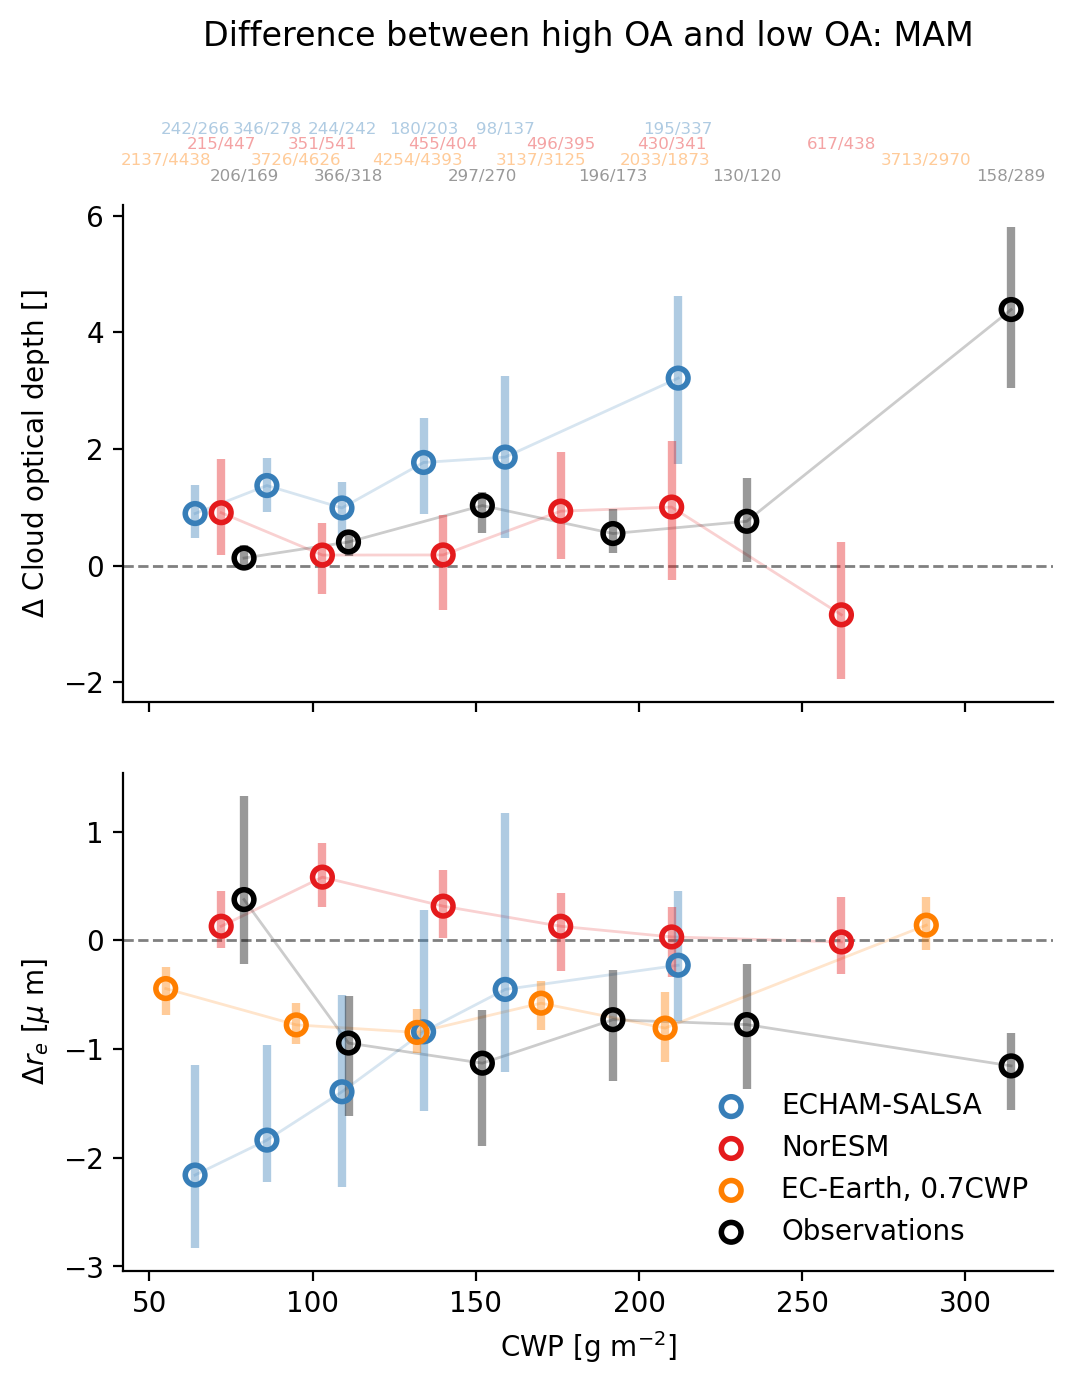

In [849]:
figsize = [6,8]
_palette = palette_OA_2
ylim = None#[0,25]
alpha_err=0.4
hue_lan_high= ['OA low', 'OA high']
hue_var = 'OA_category'

ylim2 =None# [-4,4]
markersize= 2

fig, axs_all = plt.subplots(3,1,figsize=figsize, sharey='row', sharex='col', dpi=200, gridspec_kw={'height_ratios': [1, 7, 7]})

ax_num =axs_all[0]
axs = axs_all[[1,2]]

x_var = 'CWP_cut2lm'

y_var1 = 'COT'
y_var2 = 'r_eff'

ylab1 = r'$\Delta $ Cloud optical depth []'
ylab2 = r'$\Delta r_e$ [$\mu$ m]'
y_pos = 0


ax = axs[0]
for ax, y_var in zip(axs,[y_var1, y_var2]):
    
    
    for key in dic_df.keys():
        if (key=='EC-Earth') and (y_var =='COT'):
            continue
        diff_med = dic_median_CI[y_var][key]['sample_median']
        df_sample_quant = dic_median_CI[y_var][key]['bootstrap_quant']
        df_number = dic_median_CI[y_var][key]['number']

        df_bootstrap_med = df_sample_quant.loc[0.5]
        plt_med = diff_med[y_var]
        label = key
        if key=='EC-Earth':
            label = f'{key}, 0.7CWP'
        ax.scatter(plt_med.index, plt_med, ec=cdic_model[key],lw=2, label=label,s=50,fc='none')
        ax.plot(plt_med.index, plt_med, c=cdic_model[key],lw=1, label='__nolegend__',zorder=-20,
               alpha=.2)
        #ax.scatter(df_bootstrap_med.index, df_bootstrap_med, c=cdic_model[key], label=key,s=200, marker='x')

        df_sample_quant_CI= df_sample_quant.drop(labels=0.5).T
        yerr = np.abs(df_sample_quant_CI.T - plt_med)
        
        ax.errorbar(plt_med.index, plt_med, yerr=yerr.values, 
                    #capsize=5,capthick=2,
                    c=cdic_model[key], linewidth=0, elinewidth=3, alpha=alpha_err,zorder=0)
        
        if y_var !=y_var2:
            continue
        df_number['n_str'] = df_number['n_low'].astype(str) + '/' + df_number['n_high'].astype(str) 
        #ax.text(df_numb.index, 

        for xi in df_number.index:
            si = df_number.loc[xi]['n_str']
            ax_num.text(xi, y_pos, si,
                    c = cdic_model[key],
                        fontsize=6,
                    horizontalalignment='center',
                        alpha=.4,
                   )
        #            transform=ax.transAxes,)
        y_pos -=.22
        
ax_num.xaxis.set_visible(False)
ax_num.yaxis.set_visible(False)
sns.despine(ax=ax_num,right=True, left = True, bottom=True, top=True)
for ax in axs:
    ax.axhline(0, c='.5',zorder=-10,lw=1, linestyle='--')
    
axs[0].set_ylabel(ylab1)
axs[1].set_ylabel(ylab2)
axs[1].set_ylim(ylim2)

axs[1].set_xlabel('CWP [g m$^{-2}$]')

ax.legend(frameon=False)

ax_num.set_title(f'Difference between high OA and low OA: {season}')

#ax_num.set_ylim([0,1])

sns.despine(ax = axs[0])
sns.despine(ax = axs[1])
fn = make_fn(hue_var, y_var1,x_var,comment=f'{y_var2}_diff_median', relplot=True)
print(fn) 

#fig.savefig(fn, dpi=150)
#fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
plt.show()

### Grid box avg

## Supplementary plots

In [850]:
hue_order = ['OA low','OA high']#[::-1]
palette_OA_2 = palette_OA[::-1]

In [851]:
order_keys = [model_name_noresm, model_name_echam, 'Observations']

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 5.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 10.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 5.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Plots/rel_plot/cloud_props_boxen_swarm_OA_category_COT_CWP_cutl_MAM.png


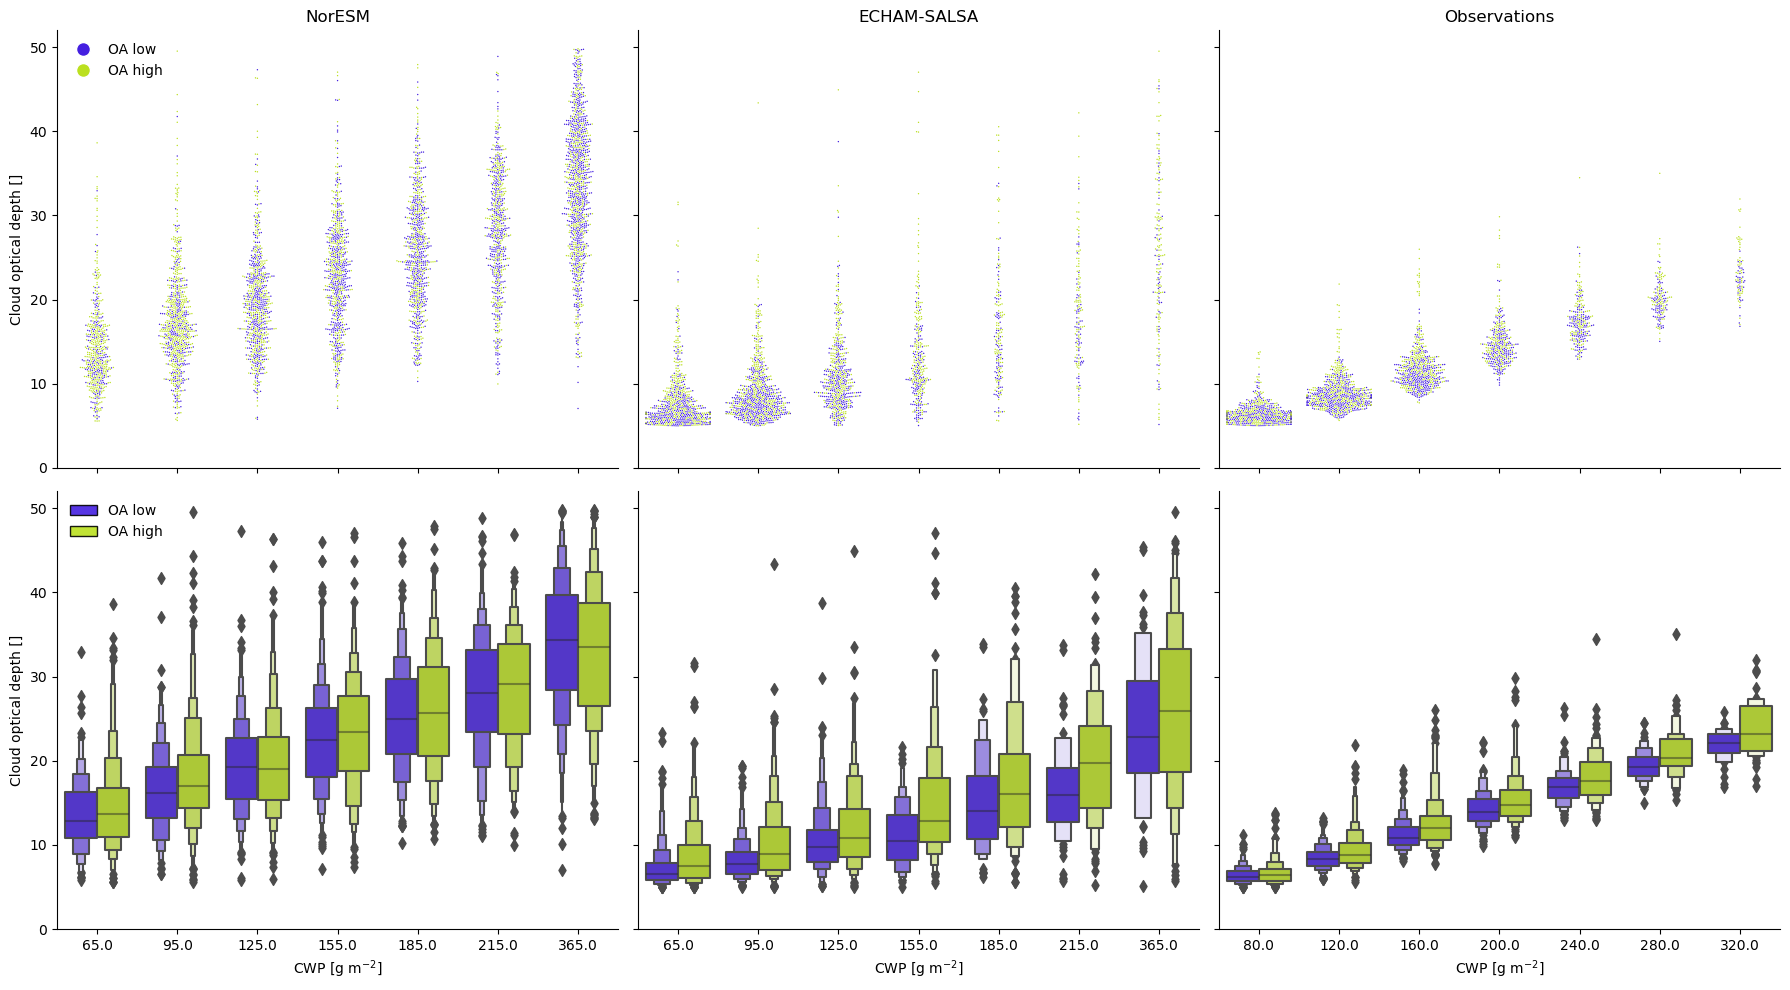

Plots/rel_plot/cloud_props_boxen_swarm_OA_category_COT_CWP_cutl_MAM.png


In [852]:
x_var = 'CWP_cutl'
y_var = 'COT'
hue_var = 'OA_category'
hue_labs = ['OA low', 'OA high']
ylim = [0,52]
figsize = [18,10]
_palette = palette_OA_2

#fig, axs = plt.subplots(2,2,figsize=figsize, sharey=True, sharex=True)
fig, axs = plt.subplots(2,3,figsize=figsize, sharey=True, sharex='col', dpi=100)

markersize= 1



for key,ax in zip(order_keys, axs[0,:]):
    
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]

    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]
    
    sns.swarmplot(
        x=x_var,
        y=y_var,
        data=_df_lim,
        hue_order=hue_order,
        hue=hue_var,
        palette=_palette,
        size = markersize,
        ax = ax,
    )
    ax.set_title(key)

#for key,ax in zip(dic_df.keys(), axs[1,:]):
for key,ax in zip(order_keys, axs[1,:]):
    
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]
    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]

    sns.boxenplot(
        x=x_var,
        y=y_var,
        data= _df_lim,
        hue_order=hue_order,#['OA low','OA high'],
        hue=hue_var,
        #kind='boxen',
        ax = ax,
        palette=_palette,
           )


    

    ## ADJUSTMENTS

for ax in axs.flatten():
    ax.legend([],[], frameon=False)
    ax.set_ylabel(None)


leg_els = [
    Patch(edgecolor='k', alpha = .9,facecolor=_palette[0], label=hue_labs[0]),
    Patch(edgecolor='k',alpha = .9, facecolor=_palette[1], label=hue_labs[1]),
          ]
axs[1,0].legend(handles = leg_els, frameon=False)

leg_els = [
     Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[0], markersize=10,
            label=hue_labs[0]
           ),
         Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[1], markersize=10,
            label=hue_labs[1]
           ),
          ]
axs[0,0].legend(handles = leg_els, frameon=False)

for ax in axs[:,0]:
    ax.set_ylabel('Cloud optical depth []')
for ax in axs[1,:]:
    ax.set_xlabel('CWP [g m$^{-2}$]')
for ax in axs[0,:]:
    ax.set_xlabel(None)

for ax in axs.flatten():

    ax.set_ylim(ylim)



sns.despine(fig)


fn = make_fn(hue_var, y_var,x_var,comment='boxen_swarm', relplot=True)
print(fn) 
#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)

plt.show()
print(fn)
### Grid box avg

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 16.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 24.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 21.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 19.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Plots/rel_plot/cloud_props_boxen_swarm_OA_category_r_eff_CWP_cut2lmid_MAM.png


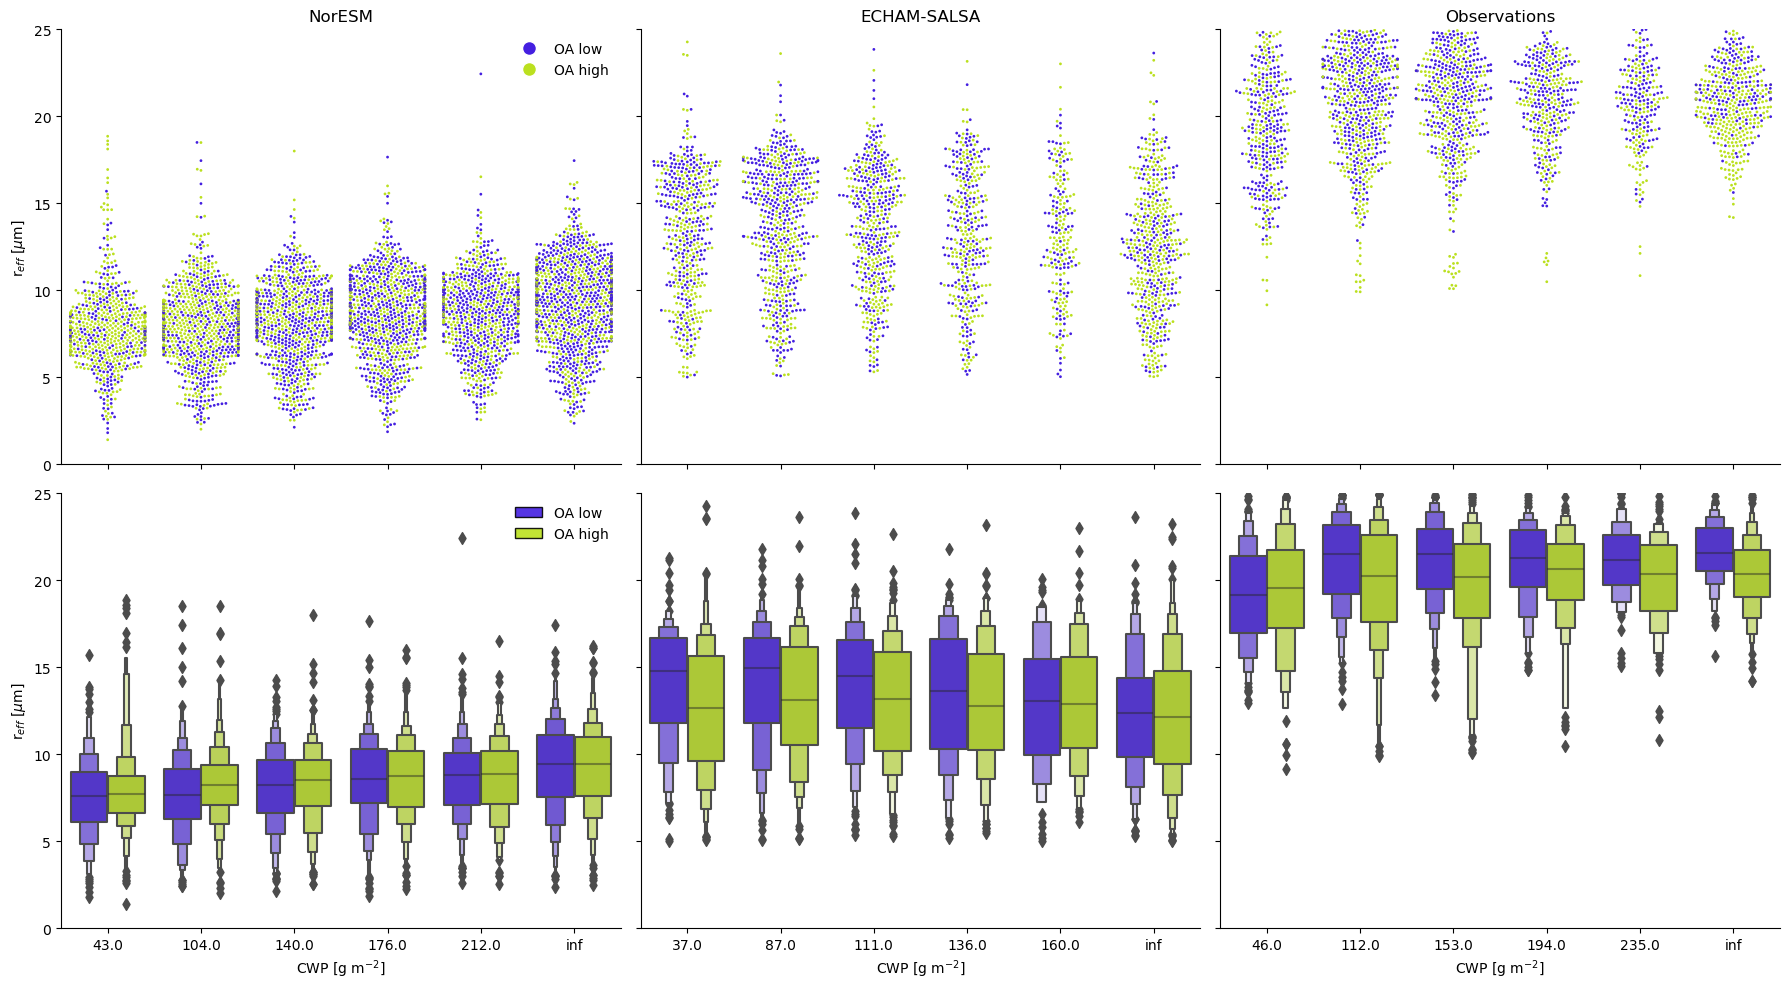

Plots/rel_plot/cloud_props_boxen_swarm_OA_category_r_eff_CWP_cut2lmid_MAM.png


In [853]:
x_var = 'CWP_cut2lmid'
y_var = 'r_eff'
hue_var = 'OA_category'
hue_labs = ['OA low', 'OA high']
ylim = [0,25]
figsize = [18,10]
_palette = palette_OA_2

#fig, axs = plt.subplots(2,2,figsize=figsize, sharey=True, sharex=True)
fig, axs = plt.subplots(2,3,figsize=figsize, sharey=True, sharex='col', dpi=100)

markersize= 2


for key,ax in zip(order_keys, axs[0,:]):
#for key,ax in zip(dic_df.keys(), axs[0,:]):

    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]

    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]
    
    sns.swarmplot(
        x=x_var,
        y=y_var,
        data=_df_lim,
        hue_order=hue_order,
        hue=hue_var,
        palette=_palette,
        size = markersize,
        ax = ax,
    )
    ax.set_title(key)

for key,ax in zip(order_keys, axs[1,:]):
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]
    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]

    sns.boxenplot(
        x=x_var,
        y=y_var,
        data= _df_lim,
        hue_order=hue_order,#['OA low','OA high'],
        hue=hue_var,
        #kind='boxen',
        ax = ax,
        palette=_palette,
           )


    

    ## ADJUSTMENTS

for ax in axs.flatten():
    ax.legend([],[], frameon=False)
    ax.set_ylabel(None)


leg_els = [
    Patch(edgecolor='k', alpha = .9,facecolor=_palette[0], label=hue_labs[0]),
    Patch(edgecolor='k',alpha = .9, facecolor=_palette[1], label=hue_labs[1]),
          ]
axs[1,0].legend(handles = leg_els, frameon=False)

leg_els = [
     Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[0], markersize=10,
            label=hue_labs[0]
           ),
         Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[1], markersize=10,
            label=hue_labs[1]
           ),
          ]
axs[0,0].legend(handles = leg_els, frameon=False)

for ax in axs[:,0]:
    ax.set_ylabel('r$_{eff}$ [$\mu$m]')
    
for ax in axs[1,:]:
    ax.set_xlabel('CWP [g m$^{-2}$]')
for ax in axs[0,:]:
    ax.set_xlabel(None)

for ax in axs.flatten():

    ax.set_ylim(ylim)



sns.despine(fig)

sns.despine(fig)
fn = make_fn(hue_var, y_var,x_var,comment='boxen_swarm', relplot=True)
print(fn) 
#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
plt.show()
print(fn)
### Grid box avg

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 16.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 24.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 21.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 19.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Plots/rel_plot/cloud_props_boxen_swarm_OA_category_r_eff_CWP_cut2lmid_MAM.png


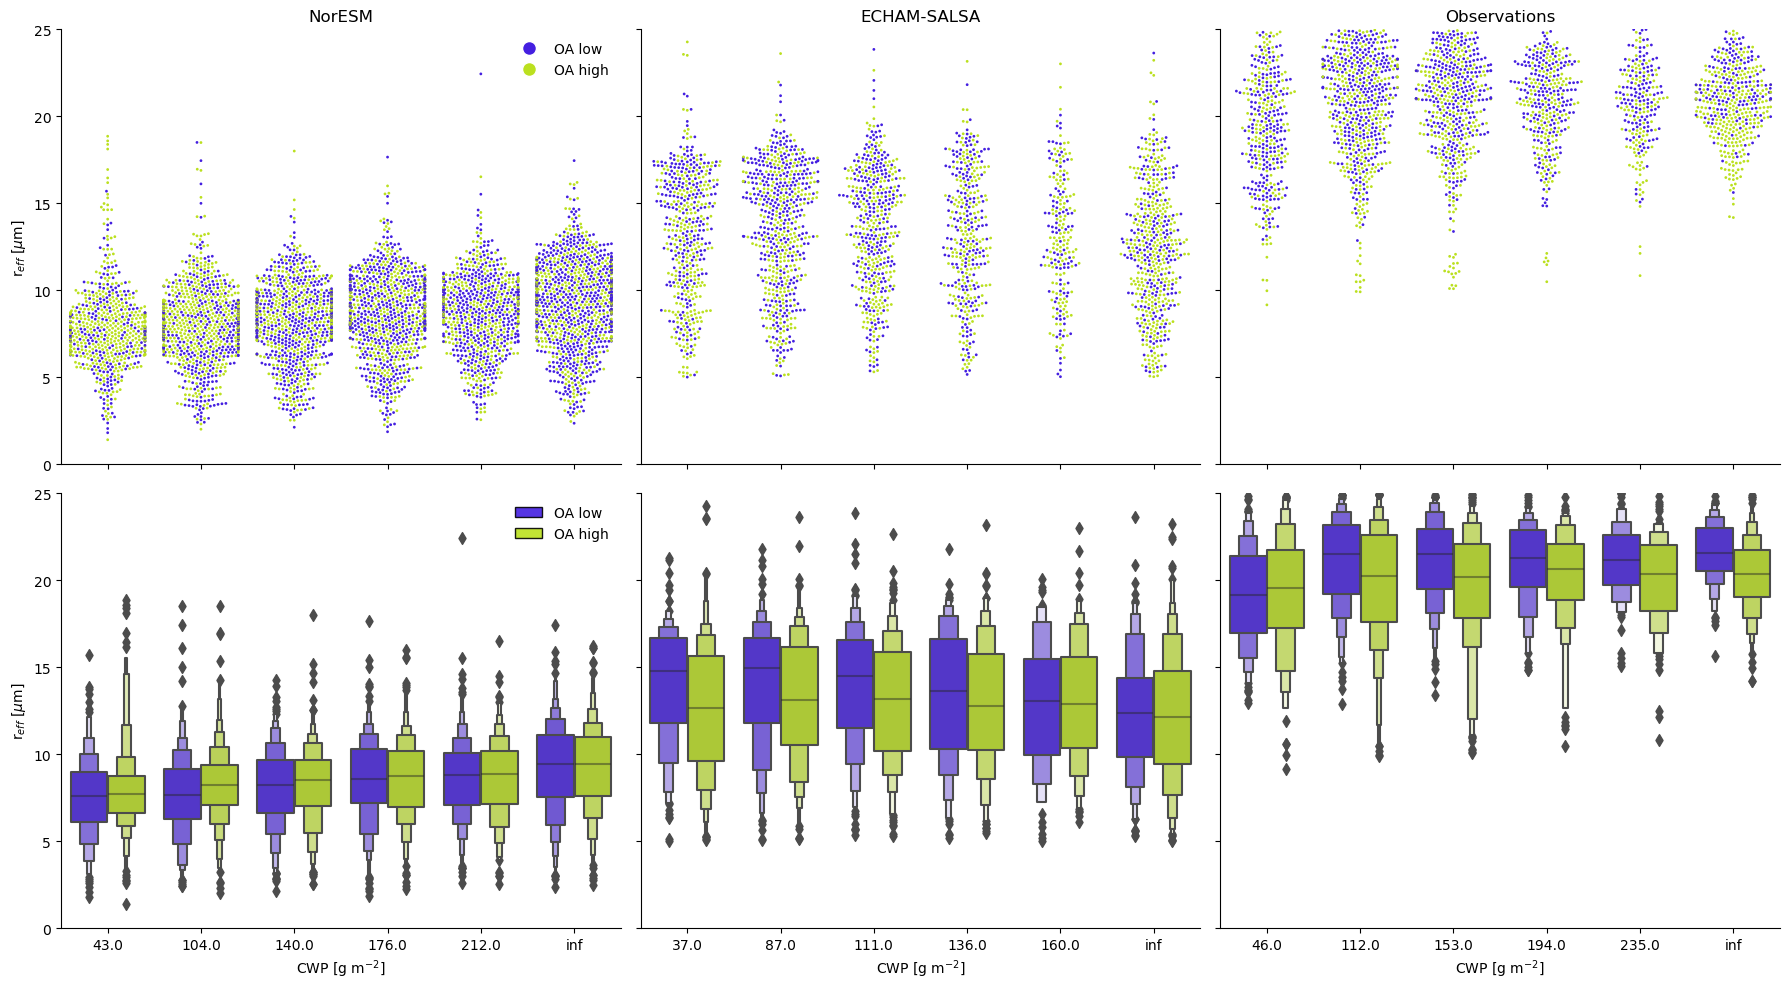

In [854]:
x_var = 'CWP_cut2lmid'
y_var = 'r_eff'
hue_var = 'OA_category'
hue_labs = ['OA low', 'OA high']
ylim = [0,25]
figsize = [18,10]
_palette = palette_OA_2

#fig, axs = plt.subplots(2,2,figsize=figsize, sharey=True, sharex=True)
fig, axs = plt.subplots(2,3,figsize=figsize, sharey=True, sharex='col', dpi=100)

markersize= 2


for key,ax in zip(order_keys, axs[0,:]):
#for key,ax in zip(dic_df.keys(), axs[0,:]):

    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]

    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]
    
    sns.swarmplot(
        x=x_var,
        y=y_var,
        data=_df_lim,
        hue_order=hue_order,
        hue=hue_var,
        palette=_palette,
        size = markersize,
        ax = ax,
    )
    ax.set_title(key)

for key,ax in zip(order_keys, axs[1,:]):
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]
    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]

    sns.boxenplot(
        x=x_var,
        y=y_var,
        data= _df_lim,
        hue_order=hue_order,#['OA low','OA high'],
        hue=hue_var,
        #kind='boxen',
        ax = ax,
        palette=_palette,
           )


    

    ## ADJUSTMENTS

for ax in axs.flatten():
    ax.legend([],[], frameon=False)
    ax.set_ylabel(None)


leg_els = [
    Patch(edgecolor='k', alpha = .9,facecolor=_palette[0], label=hue_labs[0]),
    Patch(edgecolor='k',alpha = .9, facecolor=_palette[1], label=hue_labs[1]),
          ]
axs[1,0].legend(handles = leg_els, frameon=False)

leg_els = [
     Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[0], markersize=10,
            label=hue_labs[0]
           ),
         Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[1], markersize=10,
            label=hue_labs[1]
           ),
          ]
axs[0,0].legend(handles = leg_els, frameon=False)

for ax in axs[:,0]:
    ax.set_ylabel('r$_{eff}$ [$\mu$m]')
    
for ax in axs[1,:]:
    ax.set_xlabel('CWP [g m$^{-2}$]')
for ax in axs[0,:]:
    ax.set_xlabel(None)

for ax in axs.flatten():

    ax.set_ylim(ylim)



sns.despine(fig)

sns.despine(fig)
fn = make_fn(hue_var, y_var,x_var,comment='boxen_swarm', relplot=True)
print(fn) 
#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
plt.show()

### Grid box avg

## Distribution of bootstrap median differences

length of 68 is 326 and 324
number of days is 160 and 164
10000
length of 95 is 385 and 342
number of days is 183 and 161
10000
length of 124 is 262 and 271
number of days is 154 and 144
10000
length of 152 is 129 and 181
number of days is 100 and 104
10000
length of 184 is 80 and 114
number of days is 60 and 81
10000
length of 213 is 63 and 99
number of days is 53 and 73
10000
length of 262 is 56 and 132
number of days is 41 and 81
10000


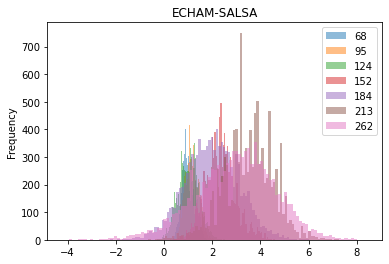

length of 68 is 170 and 362
number of days is 95 and 112
10000
length of 95 is 265 and 487
number of days is 124 and 137
10000
length of 126 is 358 and 360
number of days is 141 and 136
10000
length of 155 is 388 and 319
number of days is 148 and 130
10000
length of 185 is 420 and 316
number of days is 156 and 128
10000
length of 214 is 348 and 288
number of days is 137 and 115
10000
length of 262 is 615 and 434
number of days is 162 and 127
10000


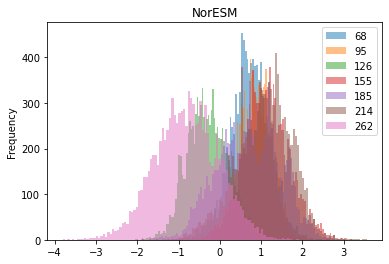

KeyError: 'COT'

In [855]:
x_var = 'CWP_cutlm'
y_var='COT'
itterations = 10000
for key in dic_df.keys():
    
    _df = dic_df[key].copy()
    
    _df_lim =_df.copy() 
    notna = (_df_lim[x_var].notna() & _df_lim[y_var].notna())&(_df_lim[hue_var].notna())
    _df_lim = _df_lim[notna]
    
    _df_low = _df_lim[_df_lim[hue_var] == hue_labs[0]]
    _df_high = _df_lim[_df_lim[hue_var] == hue_labs[1]]
        
        
    df_sample_med =bootstrap_subset(_df_low,_df_high, 
                               #quantiles = None,
                               var=y_var, category=x_var, itts=itterations)

    
    
    for ca in df_sample_med.columns:
        df_sample_med[ca].plot.hist(alpha=0.5, label=ca, bins=100)
    plt.title(key)
    plt.legend()
    
    plt.show()